In [575]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os import path
from scipy.signal import lfilter
from scipy.linalg import eigh, block_diag
from numpy.linalg import inv, det, pinv
from numpy import kron, log, eye, diag, zeros, ones, empty
from pandas.tseries.offsets import MonthBegin
from collections import namedtuple

from pandas import MultiIndex as MI

import pickle
import warnings
import sys

idx = pd.IndexSlice

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Define functions

## DFM structure

In [576]:
dp4 = lambda x: '{:,.4f}'.format(x)
dp2 = lambda x: '{:,.2f}'.format(x)

In [577]:
DFModel = namedtuple('DFModel', 'A C Q R Z_0 V_0')

DFMStructure = namedtuple('DFMStructure', 'r p Rcon q')

# LL: array of loglik, converged = 1 if converged, X_sm: smoothed X, X_mean: mean of transformed X
# X_std: standard deviation of transformed X, X_nsm: smoothed (transformed normalized) X,
# Z: smooted factor, M: estimated Model parameters (A, C, Q, R, Z_0, V_0), par: parameters for EM estimation
# X: transformed (filtered) observed variables, S: Model structure (r, p, Rcon, q),
# spec: description of observed variables (freq, transformation type, name, etc.),
# blocks: description of block strucre
DFMResult = namedtuple('DFMResult', 'LL converged X_sm X_mean X_std X_nsm Z M par X S spec blocks')

optNaN = namedtuple('optNaN', 'method k')

# parameters for EM loop
parEM = namedtuple('parEM', 'threshold max_iter gamma')

In [578]:
def DFM_structure(blocks, p = 1):
    
    # Number of factors for each block
    r = pd.Series(np.ones(blocks.shape[1], dtype=int), index=blocks.columns)  
    
    # Number of lags in autoregressive of factor
    p = 1                                                 
    
    # Contraints on the loadings of the quartrly variables
    Rcon = np.array([[2, -1,  0,  0,  0],                         
                     [3,  0, -1,  0,  0],
                     [2,  0,  0, -1,  0],
                     [1,  0,  0,  0, -1]])
    q = np.zeros(4)

    return DFMStructure(r, p, Rcon, q)

In [579]:
def dfm_copy(M, to_numpy=True):
    
    A, C, Q, R, Z_0, V_0 = M
    
    if to_numpy:
        Ac = A.to_numpy().copy()
        Cc = C.to_numpy().copy()
        Qc = Q.to_numpy().copy()
        Rc = R.to_numpy().copy()
        Z_0c = Z_0.to_numpy().copy()
        V_0c = V_0.to_numpy().copy()
    else:
        Ac = A.copy()
        Cc = C.copy()
        Qc = Q.copy()
        Rc = R.copy()
        Z_0c = Z_0.copy()
        V_0c = V_0.copy()
        
    return Ac, Cc, Qc, Rc, Z_0c, V_0c

## InitCond

### InitCond

In [580]:
def InitCond(X, DFMS, spec, blocks, optNaN):

    r, p, Rcon, q = DFMS
    
    nQ = sum(spec.Frequency.eq('q'));   # Number of quarterly series
    Qv = spec.loc[spec.Frequency.eq('q')].index.tolist()
    Mv = spec.loc[spec.Frequency.eq('m')].index.tolist()

    pC = Rcon.shape[1]    # 5, 'tent' structure size (quarterly to monthly)
    ppC = max(p, pC)

    # OPTS = pd.Series({'disp':0}) # turns off diagnostic information for eigenvalue computation
    xBal, indNaN = remNaNs_spline(X, optNaN)

    T, N = xBal.shape

    xNaN = xBal.copy()
    xNaN[indNaN] = np.nan   # set missing values equal to NaN

    res = xBal.copy()
    resNaN = xNaN.copy()

    # Initialize model coefficient output
    # C = np.empty((25, 0), int)
    C = pd.DataFrame()
    A = pd.DataFrame()
    Q = pd.DataFrame()
    V_0 = pd.DataFrame()

    # Set the first observations as NaNs: For quarterly-monthly aggreg. scheme
    indNaN.iloc[:pC-1, :] = True

    for r_i, b in zip(r, blocks.columns):    # loop for each block

        # Observation eq.
        C_i = pd.DataFrame(np.zeros((N, r_i*ppC)), index=spec.index)
        # lags = [0, 1, ..., ppC], factors = [1, 2, ..., r_i]
        C_i.columns = pd.MultiIndex.from_product([range(ppC), range(1, r_i+1)]) 
        idx_iM = blocks.loc[spec.Frequency.eq('m') & blocks[b].eq(1)].index
        idx_iQ = blocks.loc[spec.Frequency.eq('q') & blocks[b].eq(1)].index

        # Return eigenvectors v with largest r_i eigenvalues d
        d, v = eigh(res.loc[:, idx_iM].cov(), subset_by_index=[idx_iM.shape[0]-r_i, idx_iM.shape[0]-1])
        v = pd.DataFrame(v, index=idx_iM, columns=list(range(1, r_i+1)))

        # Flip sign for cleaner output. Gives equivalent results without this section
        v *= ((sum(v.squeeze()) > 0) * 2 - 1)

        # For monthly series with loaded blocks (rows), replace with eigenvector
        # This gives the loading
        C_i.loc[idx_iM, 0] = pd.concat([v], axis=1, keys=[0])
        f = res.loc[:, idx_iM].dot(v);  # Data projection for eigenvector direction
        F = pd.DataFrame(index=X.iloc[ppC-1:].index)

        # Lag matrix using loading. This is later used for quarterly series
        for kk in range(max(p+1, pC)):
            f_lag = pd.concat([f.shift(kk)], axis=1, keys=[kk])
            F = pd.concat([F, f_lag], axis=1, join='inner')

        Rcon_i = np.kron(Rcon, np.eye(r_i))  # Quarterly-monthly aggregate scheme
        q_i = np.kron(q, np.zeros(r_i))      # Rcon_i * C_i = q_i

        # Produces projected data with lag structure (so pC-1 fewer entries)
        ff = F.iloc[:, :r_i*pC]
        

        for j in idx_iQ: # Loop for quarterly variables
            # For series j, values are dropped to accommodate lag structure
            xx_j = resNaN[j].iloc[pC-1:].copy()

            if (~xx_j.isnull()).sum().squeeze() < ff.shape[1] + 2:
                xx_j = res[j].iloc[pC-1:]              # Replaces xx_j with spline if too many NaNs

            ff_j = ff.loc[~xx_j.isnull(), :]

            xx_j = xx_j.loc[~xx_j.isnull()]
            iff_j = inv(ff_j.T.dot(ff_j))

            Cc = iff_j.dot(ff_j.T).dot(xx_j)    # least squares

            # Spline data monthly to quarterly conversion
            Cc = Cc - iff_j.dot(Rcon_i.T).dot(inv(Rcon_i.dot(iff_j).dot(Rcon_i.T))).dot(Rcon_i.dot(Cc))
            # Cc = Cc - iff_j.dot(Rcon_i.T).dot(inv(Rcon_i.dot(iff_j).dot(Rcon_i.T))).dot((Rcon_i.dot(Cc)-q_i))

            C_i.loc[j].iloc[:pC*r_i] = Cc

            
        # Zeros in first pC-1 entries (replace dropped from lag)
        ff = pd.concat([pd.DataFrame(0, index=res.iloc[:pC-1].index, columns=ff.columns), ff], axis=0)

        # Residual calculations
        res = res.values - ff.dot(C_i.T)
        resNaN = res.copy()
        resNaN[indNaN] = np.nan

        C = pd.concat([C, pd.concat([C_i], axis=1, keys=[b])], axis=1)

        F.columns = pd.MultiIndex.from_tuples(F.columns)
        F.columns.names = ['p', 'f']

        ## Transition equation
        z = F.loc[:, 0]    # Projected data (no lag)
        Z = F.loc[:, 1:p]  # Data with lag 1

        # Initialize transition matrix
        # f_t = A * f_(t-1)
        A_i = pd.DataFrame(0, index=F.columns, columns=[(i+1,j) for i,j in F.columns])
        A_i.columns = pd.MultiIndex.from_tuples(A_i.columns)
        A_temp = inv(Z.T.dot(Z)).dot(Z.T).dot(z)   # OLS coefficient of AR(p)

        A_i.loc[idx[0, :], idx[:p, :]] = A_temp.T
        A_i.loc[idx[1:, :], idx[:(ppC-1), :]] = np.eye(r_i*(ppC-1))

        Q_i = pd.DataFrame(0, index=F.columns, columns=F.columns)
        e = z.squeeze() - Z.dot(A_temp).squeeze()                  # VAR residuals
        Q_i.loc[0, 0] = np.cov(e, rowvar=False)                    # VAR covariance matrix

        initV_i = inv(eye((r_i*ppC)**2)-kron(A_i,A_i)).dot(Q_i.values.flatten('F')).reshape(r_i*ppC,r_i*ppC,order='F')
        initV_i = pd.DataFrame(initV_i, index=Q_i.index, columns=Q_i.columns)

        # Gives top left block for the transition matrix
        A = bdkg_index(A, A_i, b)
        Q = bdkg_index(Q, Q_i, b)
        V_0 = bdkg_index(V_0, initV_i, b)
        

    for df in [A, Q, V_0]:
        df.index = pd.MultiIndex.from_tuples(df.index)
        df.columns = pd.MultiIndex.from_tuples(df.columns)


    # C = [C Cm Cy]
    Cm = pd.DataFrame(np.eye(N), index=spec.index, columns=spec.index).loc[:, Mv]
    Cm.columns = pd.MultiIndex.from_product([Cm.columns, [0], [1]])
    C = pd.concat([C, Cm], axis=1)

    Cy = pd.DataFrame(0, index=spec.index, columns=pd.MultiIndex.from_product([Qv, range(pC), [1]]))
    for j in Qv:
        Cy.loc[j, j] = [1, 2, 3, 2, 1]

    # Monthly-quarterly aggregate scheme
    C = pd.concat([C, Cy], axis=1)
    R = pd.DataFrame(np.diag(resNaN.var()), index=resNaN.columns, columns=resNaN.columns)

    BM = pd.DataFrame(0, index=Mv, columns=Mv);        # Initialize monthly transition matrix values
    SM = pd.DataFrame(0, index=Mv, columns=Mv);        # Initialize monthly residual covariance matrix values

    for v in Mv:
        # Set observation equation residual covariance matrix diagonal
        R.loc[v, v] = 1e-04;

        # Subsetting series residuals for series i
        res_i = resNaN.loc[:, v].copy();

        # Returns number of leading/ending zeros
        rem_i = res_i.isnull()
        leadZero = rem_i.cumsum() == list(range(1, rem_i.shape[0]+1))
        endZero = (rem_i.sum() - rem_i.cumsum() + rem_i) == list(range(rem_i.shape[0], 0, -1))

        # Truncate leading and ending zeros
        res_i = res.loc[:, [v]].copy();
        res_i = res_i.loc[~leadZero & ~endZero]

        # Linear regression: AR 1 process for monthly series residuals
        BM.loc[[v], [v]] = inv(res_i.iloc[:-1].T.dot(res_i.iloc[:-1])).dot(res_i.iloc[:-1].T).dot(res_i.iloc[1:])
        SM.loc[[v], [v]] = (res_i-res_i.shift(1).dot(BM.loc[[v],[v]])).cov();  # Residual covariance matrix

    sig_e = pd.DataFrame(0, index=Qv, columns=['sig']) 

    for v in Qv:
        sig_e.loc[v] = R.loc[v, v] / 19.0
        R.loc[v, v] = 1e-04                 # Covariance for obs matrix residuals

    # For BQ, SQ
    rho0 = 0.1;
    temp = np.zeros((5,5));
    temp[0,0] = 1;

    # Blocks for covariance matrices
    SQ = kron(np.diag((1-rho0**2)*sig_e.squeeze()), temp)
    BQ = kron(np.eye(nQ), np.append([[rho0, 0, 0, 0, 0]], 
                                    np.append(np.eye(4), np.zeros((4,1)), axis=1), axis=0))
    initViQ = inv(np.eye((ppC*nQ)**2)-kron(BQ,BQ)).dot(SQ.flatten('F')).reshape(ppC*nQ,ppC*nQ)
    initViM = np.diag(1/np.diag(np.eye(BM.shape[0])-BM**2))*SM

    BQ = pd.DataFrame(BQ, index=pd.MultiIndex.from_product([Qv, range(pC)]), 
                      columns=pd.MultiIndex.from_product([Qv, range(1, pC+1)]))

    SQ = pd.DataFrame(SQ, index=pd.MultiIndex.from_product([Qv, range(pC)]), 
                      columns=pd.MultiIndex.from_product([Qv, range(pC)]))

    initViQ = pd.DataFrame(initViQ, index=pd.MultiIndex.from_product([Qv, range(pC)]), 
                           columns=pd.MultiIndex.from_product([Qv, range(pC)]))

    # Output
    BM.index = BM.columns = Cm.columns
    BQ.index = BQ.columns = Cy.columns
    SM.index = SM.columns = Cm.columns
    SQ.index = SQ.columns = Cy.columns
    initViM.index = initViM.columns = Cm.columns
    initViQ.index = initViQ.columns = Cy.columns
    
    A = bkdg_flat_index(bkdg_flat_index(A, BM), BQ)                # Observation matrix
    Q = bkdg_flat_index(bkdg_flat_index(Q, SM), SQ)                # Residual covariance matrix (transition)
    Z_0 = pd.Series(np.zeros(A.shape[0]), index=A.index)           # States
    V_0 = bkdg_flat_index(bkdg_flat_index(V_0, initViM), initViQ)  # Covariance of states
    
    A.index = A.columns = pd.MultiIndex.from_tuples(A.index)
    Q.index = Q.columns = pd.MultiIndex.from_tuples(Q.index)
    V_0.index = V_0.columns = pd.MultiIndex.from_tuples(Q.index)
    Z_0.index = pd.MultiIndex.from_tuples(Q.index)

    return DFModel(A, C, Q, R, Z_0, V_0)

### load_spec, load_data, nanLE, bdkg_index, bdkg_flat_index

In [581]:
def load_spec(filename):
    spec = pd.read_excel(filename, sheet_name='spec');

    # keep variables with Model == 1 and drop 'Model' column
    spec = spec.loc[spec.Model.eq(1)].drop('Model', axis=1)

    spec_sort = pd.DataFrame()
    for f in ['d', 'w', 'm', 'q', 'sa', 'a']:
        spec_sort = pd.concat([spec_sort, spec.loc[spec.Frequency.eq(f)]], axis = 0)

    UnitsTransformed_dict = {'lin':'Levels (No Transformation)', 'chg':'Change (Difference)',
                             'ch1':'Year over Year Change (Difference)', 'pch':'Percent Change',
                             'pc1':'Year over Year Percent Change', 'pca':'Percent Change (Annual Rate)',
                             'cch':'Continuously Compounded Rate of Change', 
                             'cca':'Continuously Compounded Annual Rate of Change', 'log':'Natural Log'}

    spec_sort['UnitsTransformed'] = spec_sort['Transformation']
    spec_sort['UnitsTransformed'] = spec_sort['UnitsTransformed'].replace(UnitsTransformed_dict)
    spec_sort = spec_sort.set_index('SeriesID')
    Blocks = spec_sort.filter(regex='^Block', axis=1)
    Blocks.columns = [i for j,i in Blocks.columns.str.split('-').tolist()]
    
    spec_sort = spec_sort[spec_sort.columns.drop(list(spec_sort.filter(regex='Block')))]

    return spec_sort, Blocks


def load_data(datafile, spec, sample_start='2000-01-01'):
    Z = pd.read_excel(datafile, sheet_name='data')
    Z = Z.set_index('Date')
    Z = Z.asfreq('MS')

    if Z.dropna(how='all', axis=0).shape[0] != Z.shape[0]:
        print('Data file has missing dates.')

    Z.index.names = ['Time']    
    Z = Z.loc[:, spec.index]

    T, N = Z.shape

    f2m = dict(zip(['m', 'q', 'sa', 'a'], [1, 3, 6, 12])) # 
    f2a = dict(zip(['m', 'q', 'sa', 'a'], [12, 4, 2, 1])) # 

    X = pd.DataFrame(np.nan, index=Z.index, columns=Z.columns)

    for var in Z.columns:
        formular = spec.loc[var, 'Transformation']
        freq = spec.loc[var, 'Frequency']
        if formular == 'lin':   # Levels (No Transformation)
            X.loc[:, var] = Z.loc[:, var]
        elif formular == 'chg': # Change (Difference)
            X.loc[:, var] = Z.loc[:, var].diff(f2m[freq])
        elif formular == 'ch1': # YoY Change (Difference)
            X.loc[:, var] = Z.loc[:, var].diff(12)
        elif formular == 'pch': # Percent Change
            X.loc[:, var] = Z.loc[:, var].pct_change(f2m[freq], fill_method=None) * 100
        elif formular == 'pc1': # YoY Percent Change
            X.loc[:, var] = Z.loc[:, var].pct_change(12, fill_method=None) * 100
        elif formular == 'pca': # Percent Change (annualised)
            X.loc[:, var] = ((Z.loc[:, var].pct_change(f2m[freq], fill_method=None) + 1)**f2a[freq] - 1) * 100
        elif formular == 'log': # Natural log
            X.loc[:, var] = np.log(Z.loc[:, var])
        else:
            print('Transformation formular not found.')        

    Z = Z.loc[sample_start:]
    X = X.loc[sample_start:]    

    return X, Z


def nanLE(rem1, X):
    nanLead = rem1.cumsum() == list(range(1, rem1.shape[0] + 1))  # 위부터 연속하여 NaN인 행 식별
    nanEnd = ((rem1.sum() - rem1.cumsum() + rem1)                 # rem1.cumsum(reverse=True)
               == list(range(rem1.shape[0], 0, -1)))              # 아래부터 연속하여 NaN인 행 식별
    nanLE = nanLead | nanEnd                                      # 위 또는 아래부터 연속하여 NaN인 행 식별
    X = X.loc[~nanLE]
    indNaN = X.isnull()
    return X, indNaN


def bdkg_index(A, A_i, b):
    index = [(bb, ii, jj) for bb, ii, jj in A.index] + [(b, ii, jj) for ii, jj in A_i.index]
    columns = [(bb, ii, jj) for bb, ii, jj in A.columns] + [(b, ii, jj) for ii, jj in A_i.columns]
    A = pd.DataFrame(block_diag(A, A_i), index=index, columns=columns)
    return A


def bkdg_flat_index(A, B):
    index = A.index.to_flat_index().tolist() + B.index.to_flat_index().tolist()
    columns = A.columns.to_flat_index().tolist() + B.columns.to_flat_index().tolist()
    A = pd.DataFrame(block_diag(A, B), index=index, columns=columns)
    return A

### remNans_spline, filtering, 

In [582]:
def filtering(X, k):
    Y = X.copy()
    for var in X.columns:
        x = X[var].copy()
        isnanx = x.isnull()
        t1 = isnanx[isnanx.eq(False)].index[0]
        t2 = isnanx[isnanx.eq(False)].index[-1]
        x[t1:t2] = x[t1:t2].interpolate('cubic')  # GDPC1 with method 2: 1.4759/1.4731, 1.4277/1.4151 (matlab/python)
        isnanx = x.isnull()
        x.loc[x.isnull()] = x.median(skipna=True)
        x_ext = np.append(np.append([x.values[0]]*k, x.values), [x.values[-1]]*k)
        x_ma = lfilter(np.ones(2*k+1)/(2*k+1), 1, x_ext)  # equivalent to filter() in MATLAB
        x_ma = x_ma[2*k:]
        x_repl = pd.Series(x_ma, index=x.index)
        x[isnanx] = x_repl[isnanx]                # very similar to matlab; 1.7855/1.7851, 1.8790/1.8795 (matlab/python)
        Y.loc[:, var] = x
    return Y

def remNaNs_spline(X, optNaN): # spline without NaNs
    indNaN = X.isnull()
    T, N = X.shape

    if optNaN.method==1:     # replace all the missing values
        for var in X.columns:
            x = X[var].copy()
            isnanx = x.isnull()
            x.loc[isnanx] = x.median(skipna=True)
            x_ext = np.append(np.append([x.values[0]]*optNaN.k, x.values), [x.values[-1]]*optNaN.k)
            x_ma = lfilter(np.ones(2*optNaN.k+1)/(2*optNaN.k+1), 1, x_ext)
            x_ma = x_ma[2*k:]
            x_repl = pd.Series(x_ma, index=x.index)
            x[isnanx] = x_repl[isnanx]
            X[var] = x
        
    elif optNaN.method==2:   # replace missing values after removing leading and closing zeros
        rem1 = indNaN.sum(axis=1) > .8 * N                            # 80% 이상 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        X = filtering(X, optNaN.k)
            
    elif optNaN.method==3: # only remove rows with leading and closing zeros
        rem1 = indNaN.sum(axis=1) == N                                # 모든 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        
    elif optNaN.method==4:  # remove rows with leading and closing zeros & replace missing values
        rem1 = indNaN.sum(axis=1) == N                                # 모든 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        X = filtering(X, optNaN.k)
        
    elif optNaN.method==5:  # replace missing values  
        indNaN = X.isnull()
        X = filtering(X, optNaN.k)
    
    return X, indNaN

## Kalman filter/smoother

### MissData

In [583]:
def MissData(y, C, R):
    # Syntax:
    # Description:
    #   Eliminates the rows in y & matrices C, R that correspond to missing 
    #   data (NaN) in y
    #
    # Input:
    #   y: Vector of observations at time t
    #   C: Observation matrix
    #   R: Covariance for observation matrix residuals
    #
    # Output:
    #   y: Vector of observations at time t (reduced)     
    #   C: Observation matrix (reduced)     
    #   R: Covariance for observation matrix residuals
    #   L: Used to restore standard dimensions(n x #) where # is the nr of 
    #      available data in y

    # Returns 1 for nonmissing series
    ix = ~np.isnan(y)

    # Index for columns with nonmissing variables
    e = np.eye(y.shape[0])
    L = e[:, ix]

    # Removes missing series
    y = y[ix]

    # Removes missing series from observation matrix
    C = C[ix, :]

    # Removes missing series from transition matrix
    R = R[ix, ix]

    return y, C, R, L

### FIS

In [584]:
def FIS(A, Zm, ZmU, Vm, VmU, loglik, k_t):

    # Applies fixed-interval smoother
    #
    #  Description:
    #    SKF() applies a fixed-interval smoother, and is used in conjunction 
    #    with SKF(). See  page 154 of 'Forecasting, structural time series models 
    #    and the Kalman filter' for more details (Harvey, 1990).
    #
    #  Input parameters:
    #    A: m-by-m transition matrix 
    #    S: structure returned by SKF() 
            #    S.Zm: m-by-nobs matrix, prior/predicted factor state vector
            #          (S.Zm(:,t) = Z_t|t-1)
            #    S.ZmU: m-by-(nobs+1) matrix, posterior/updated state vector
            #           (S.Zm(t+1) = Z_t|t)
            #    S.Vm: m-by-m-by-nobs array, prior/predicted covariance of factor
            #          state vector (S.Vm(:,:,t) = V_t|t-1)  
            #    S.VmU: m-by-m-by-(nobs+1) array, posterior/updated covariance of
            #           factor state vector (S.VmU(:,:,t+1) = V_t|t)
            #    S.loglik: scalar, value of likelihood function
            #    S.k_t: k-by-m Kalman gain
    #
    #  Output parameters:
    #    S: FIS() adds the following smoothed estimates to the S structure: 
    #    - S.ZmT: m-by-(nobs+1) matrix, smoothed states
    #             (S.ZmT(:,t+1) = Z_t|T) 
    #    - S.VmT: m-by-m-by-(nobs+1) array, smoothed factor covariance
    #             matrices (S.VmT(:,:,t+1) = V_t|T = Cov(Z_t|T))
    #    - S.VmT_1: m-by-m-by-nobs array, smoothed lag 1 factor covariance
    #               matrices (S.VmT_1(:,:,t) = Cov(Z_t Z_t-1|T))
    #
    #  Model:
    #   Y_t = C_t Z_t + e_t for e_t ~ N(0, R)
    #   Z_t = A Z_{t-1} + mu_t for mu_t ~ N(0, Q)

    ## ORGANIZE INPUT ---------------------------------------------------------
    # Initialize output matrices    
    nobs, m = Zm.shape
    ZmT = np.zeros((nobs+1,m))
    VmT = np.zeros((nobs+1,m,m))

    # Fill the final period of ZmT, VmT with SKF() posterior values
    ZmT[nobs,:] = ZmU[nobs, :].squeeze()
    VmT[nobs,:,:] = VmU[nobs,:,:].squeeze()

    # Initialize VmT_1 lag 1 covariance matrix for final period
    VmT_1 = np.zeros((nobs,m,m))
    VmT_1[-1,:,:] = (np.eye(m)-k_t).dot(A).dot(VmU[nobs-1,:,:].squeeze())

    # Used for recursion process. See companion file for details
    J_2 = VmU[nobs-1,:,:].squeeze().dot(A.T).dot(pinv(Vm[nobs-1,:,:]))

    
    ## RUN SMOOTHING ALGORITHM ----------------------------------------------
    # Loop through time reverse-chronologically (starting at final period nobs)
    for t in range(nobs-1, -1, -1):
        # Store posterior and prior factor covariance values 
        VmUt = VmU[t,:,:].squeeze()
        Vmt = Vm[t,:,:].squeeze()
        
        # Store previous period smoothed factor covariance and lag-1 covariance
        V_T = VmT[t+1,:,:].squeeze()
        V_T1 = VmT_1[t,:,:].squeeze()
        
        J_1 = J_2.copy()
        
        # Update smoothed factor estimate
        ZmT[t,:] = ZmU[t,:] + J_1.dot(ZmT[t+1,:] - A.dot(ZmU[t,:]))
        
        # Update smoothed factor covariance matrix
        VmT[t,:,:] = VmUt + J_1.dot(V_T - Vmt).dot(J_1.T)
        
        
        if t > 0:
            # Update weight
            J_2 = VmU[t-1,:,:].squeeze().dot(A.T).dot(pinv(Vm[t-1,:,:].squeeze()))
            
            # Update lag 1 factor covariance matrix 
            VmT_1[t-1,:,:] = VmUt.dot(J_2.T) + J_1.dot(V_T1 - A.dot(VmUt)).dot(J_2.T)
            

    return ZmT, VmT, VmT_1

### SKF

In [585]:
def SKF(Y, A, C, Q, R, Z_0, V_0):
    #  Description:
    #    SKF() applies the Kalman filter
    #
    #  Input parameters:
    #    Y: k-by-nobs matrix of input data
    #    A: m-by-m transition matrix 
    #    C: k-by-m observation matrix
    #    Q: m-by-m covariance matrix for transition equation residuals (mu_t)
    #    R: k-by-k covariance for observation matrix residuals (e_t)
    #    Z_0: 1-by-m vector, initial value of state
    #    V_0: m-by-m matrix, initial value of state covariance matrix
    #
    #  Output parameters:
    #    S.Zm: m-by-nobs matrix, prior/predicted factor state vector
    #          (S.Zm(:,t) = Z_t|t-1)
    #    S.ZmU: m-by-(nobs+1) matrix, posterior/updated state vector
    #           (S.Zm(t+1) = Z_t|t)
    #    S.Vm: m-by-m-by-nobs array, prior/predicted covariance of factor
    #          state vector (S.Vm(:,:,t) = V_t|t-1)  
    #    S.VmU: m-by-m-by-(nobs+1) array, posterior/updated covariance of
    #           factor state vector (S.VmU(:,:,t+1) = V_t|t)
    #    S.loglik: scalar, value of likelihood function
    #    S.k_t: k-by-m Kalman gain

    ## INITIALIZE OUTPUT VALUES ---------------------------------------------   
    # Output structure & dimensions of state space matrix
    k, m = C.shape   # k * m: observable variables and factors

    # Outputs time for data matrix. "number of observations"
    nobs  = Y.shape[1]

    # Instantiate output
    Zm     = np.ones((nobs, m)) * np.nan       # Z_t | t-1 (prior)
    Vm     = np.ones((nobs, m, m)) * np.nan    # V_t | t-1 (prior)
    ZmU    = np.ones((nobs+1, m)) * np.nan;    # Z_t | t (posterior/updated)
    VmU    = np.ones((nobs+1, m, m)) * np.nan; # V_t | t (posterior/updated)
    loglik = 0

    ## SET INITIAL VALUES ----------------------------------------------------
    Zu = Z_0.copy()  # Z_0|0 (In below loop, Zu gives Z_t | t)
    Vu = V_0.copy()  # V_0|0 (In below loop, Vu guvse V_t | t)

    # Store initial values
    ZmU[0, :]     = Zu.copy()
    VmU[0, :, :]  = Vu.copy()

    ## KALMAN FILTER PROCEDURE ----------------------------------------------
    for t in range(nobs):
        
        ### CALCULATING PRIOR DISTIBUTION----------------------------------
        # Use transition eqn to create prior estimate for factor
        # i.e. Z = Z_t|t-1
        Z = A.dot(Zu)

        # Prior covariance matrix of Z (i.e. V = V_t|t-1)
        # Var(Z) = Var(A*Z+u_t) = A*Vu*A' + Q
        V = A.dot(Vu).dot(A.T) + Q
        V = (V+V.T)/2               # Trick to make symmetric

        ### CALCULATING POSTERIOR DISTRIBUTION ----------------------------
        # Removes missing series: These are removed from Y, C, and R
        Y_t, C_t, R_t, L = MissData(Y[:, t], C, R)


        # Check if y_t contains no data. If so, replace Zu and Vu with prior.
        if Y_t.size==0:
            Zu = Z
            Vu = V
        else:
            # Steps for variance and population regression coefficients:
            # Var(c_t*Z_t + e_t) = c_t Var(A) c_t' + Var(u) = c_t*V *c_t' + R
            VC = V.dot(C_t.T)
            iF = inv(C_t.dot(VC) + R_t)

            # Matrix of population regression coefficients (QuantEcon eqn #4)
            VCF = VC.dot(iF)

            # Gives difference between actual and predicted observation
            # matrix values
            innov = Y_t - C_t.dot(Z)

            # Update estimate of factor values (posterior)
            Zu = Z  + VCF.dot(innov)

            # Update covariance matrix (posterior) for time t
            Vu = V  - VCF.dot(VC.T)
            Vu = (Vu+Vu.T)/2 # Approximation trick to make symmetric

            # Update log likelihood 
            loglik = loglik + 0.5*(log(det(iF)) - innov.T.dot(iF).dot(innov))


        ### STORE OUTPUT----------------------------------------------------
        # Store covariance and observation values for t-1 (priors)
        Zm[t, :] = Z
        Vm[t, :, :] = V

        # Store covariance and state values for t (posteriors)
        # i.e. Zu = Z_t|t   & Vu = V_t|t
        ZmU[t+1, :] = Zu
        VmU[t+1, :, :] = Vu


    # Store Kalman gain k_t
    if Y_t.size==0:
        k_t = np.zeros((m,m))
    else:
        k_t = VCF.dot(C_t)

    return Zm, ZmU, Vm, VmU, loglik, k_t

### runKF

In [586]:
def runKF(Y, M):
    #  Description:
    #    runKF() applies a Kalman filter and fixed-interval smoother. The
    #    script uses the following model:
    #           Y_t = C_t Z_t + e_t for e_t ~ N(0, R)
    #           Z_t = A Z_{t-1} + mu_t for mu_t ~ N(0, Q)

    #  Throughout this file:
    #    'm' denotes the number of elements in the state vector Z_t.
    #    'k' denotes the number of elements (observed variables) in Y_t.
    #    'nobs' denotes the number of time periods for which data are observed.
    #
    #  Input parameters:
    #    Y: k-by-nobs matrix of input data
    #    A: m-by-m transition matrix 
    #    C: k-by-m observation matrix
    #    Q: m-by-m covariance matrix for transition equation residuals (mu_t)
    #    R: k-by-k covariance for observation matrix residuals (e_t)
    #    Z_0: 1-by-m vector, initial value of state
    #    V_0: m-by-m matrix, initial value of state covariance matrix
    #
    #  Output parameters:
    #    zsmooth: k-by-(nobs+1) matrix, smoothed factor estimates
    #             (i.e. zsmooth(:,t+1) = Z_t|T)
    #    Vsmooth: k-by-k-by-(nobs+1) array, smoothed factor covariance matrices
    #             (i.e. Vsmooth(:,:,t+1) = Cov(Z_t|T))
    #    VVsmooth: k-by-k-by-nobs array, lag 1 factor covariance matrices
    #              (i.e. Cov(Z_t,Z_t-1|T))
    #    loglik: scalar, log-likelihood
    #
    #  References:
    #  - QuantEcon's "A First Look at the Kalman Filter"
    #  - Adapted from replication files for:
    #    "Nowcasting", 2010, (by Marta Banbura, Domenico Giannone and Lucrezia 
    #    Reichlin), in Michael P. Clements and David F. Hendry, editors, Oxford 
    #    Handbook on Economic Forecasting.
    #
    # The software can be freely used in applications. 
    # Users are kindly requested to add acknowledgements to published work and 
    # to cite the above reference in any resulting publications
    states = pd.MultiIndex.from_tuples(M.A.index)
    ps = Y.columns
    ps_0 = pd.date_range(ps[0] - MonthBegin(), ps[-1], freq=ps.freq)
    
    ps_states = MI.from_tuples([(i, j, p, q) for i in ps for j, p, q in states.to_flat_index()])
    ps_0_states = MI.from_tuples([(i, j, p, q) for i in ps_0 for j, p, q in states.to_flat_index()])
    
    Y = Y.to_numpy().copy()
    A, C, Q, R, Z_0, V_0 = dfm_copy(M)

    Zm, ZmU, Vm, VmU, loglik, k_t = SKF(Y, A, C, Q, R, Z_0, V_0)   # Kalman filter
    ZmT, VmT, VmT_1 = FIS(A, Zm, ZmU, Vm, VmU, loglik, k_t)        # Fixed interval smoother

    # Organize output 
    Zsmooth = pd.DataFrame(ZmT.T, index=states, columns=ps_0)
    
    VmT = np.moveaxis(VmT, 0, -1).reshape(len(states), len(ps_0_states), order='F')
    VmT_1 = np.moveaxis(VmT_1, 0, -1).reshape(len(states), len(ps_states), order='F')
    
    Vsmooth = pd.DataFrame(VmT, index=states, columns=ps_0_states)
    VVsmooth = pd.DataFrame(VmT_1, index=states, columns=ps_states)

    return Zsmooth, Vsmooth, VVsmooth, loglik, ps, ps_0

### get_smoothed

In [587]:
def get_smoothed(dfmr_filename, t_var, factors):
    
    Res = DFMResult(**pickle.load(open(dfmr_filename,"rb")))
    
    X = Res.X.T
    Z = Res.Z
    C = Res.M.C
    X_std = Res.X_std
    X_mean = Res.X_mean
    
    x_sm = (Z.loc[:, idx[factors]].dot(C.loc[t_var, idx[factors]].T)*X_std.loc[t_var] + X_mean.loc[t_var])
    x_tr = X[t_var].dropna()
    
    return x_sm, x_tr

## EM

### em_converged

In [588]:
def em_converged(loglik, pre_loglik, threshold=1e-4, check_decreased=1):
    #  checks whether EM algorithm has converged
    #
    #  Syntax:
    #    [converged, decrease] = em_converged(loglik, pre_loglik, threshold, check_increased)
    #
    #  Description:
    #    em_converged() checks whether EM has converged. Convergence occurs if
    #    the slope of the log-likelihood function falls below 'threshold'(i.e.
    #    f(t) - f(t-1)| / avg < threshold) where avg = (|f(t)| + |f(t-1)|)/2
    #    and f(t) is log lik at iteration t. 'threshold' defaults to 1e-4.
    #
    #    This stopping criterion is from Numerical Recipes in C (pg. 423).
    #    With MAP estimation (using priors), the likelihood can decrease
    #    even if the mode of the posterior increases.
    #
    #  Input arguments:
    #    loglik: Log-likelihood from current EM iteration
    #    pre_loglik: Log-likelihood from previous EM iteration
    #    threshold: Convergence threshhold. The default is 1e-4.
    #    check_decreased: Returns text output if log-likelihood decreases.
    #
    #  Output:
    #    converged (numeric): Returns 1 if convergence criteria satisfied, and 0 otherwise.
    #    decrease (numeric): Returns 1 if loglikelihood decreased.

    ## Instantiate variables
    # Threshhold arguments: Checks default behavior
    # if nargin < 3, threshold = 1e-4; end
    # if nargin < 4, check_decreased = 1; end

    # Initialize output
    converged = 0;
    decrease = 0;

    ## Check if log-likelihood decreases (optional)
    if check_decreased:
        if loglik < pre_loglik - 1e-1: # allow for a little imprecision
            print('loglik decreased by {:,.1f} from {:,.1f} to {:,.1f}'.format(pre_loglik-loglik, 
                                                                               pre_loglik, loglik))
            decrease = 1

    ## Check convergence criteria
    delta_loglik = abs(loglik - pre_loglik)               # Difference in loglik
    avg_loglik = (abs(loglik) + abs(pre_loglik) + np.spacing(1))/2

    if (delta_loglik / avg_loglik) < threshold:
        converged = 1                                          # Check convergence
        print('loglik converged with loglik {:.4f}'.format(loglik))

    return converged, decrease, (delta_loglik / avg_loglik)

### EMstep

In [589]:
def EMstep(y, M, S, blocks, spec):

    #  Applies EM algorithm for parameter reestimation
    #
    #  Syntax:
    #  C_new, R_new, A_new, Q_new, Z_0, V_0, loglik
    #    = EMstep(y, A, C, Q, R, Z_0, V_0, r, p, Rcon, q, blocks, spec)
    #
    #  Description:
    #    EMstep reestimates parameters based on the Estimation Maximization (EM)
    #    algorithm. This is a two-step procedure:
    #    (1) E-step: the expectation of the log-likelihood is calculated using
    #        previous parameter estimates.
    #    (2) M-step: Parameters are re-estimated through the maximisation of
    #        the log-likelihood (maximize result from (1)).
    #
    #    See "Maximum likelihood estimation of factor models on data sets with
    #    arbitrary pattern of missing data" for details about parameter
    #    derivation (Banbura & Modugno, 2010). This procedure is in much the
    #    same spirit.
    #
    #  Input:
    #    y:      Series data
    #    A:      Transition matrix
    #    C:      Observation matrix
    #    Q:      Covariance for transition equation residuals
    #    R:      Covariance for observation matrix residuals
    #    Z_0:    Initial values of factors
    #    V_0:    Initial value of factor covariance matrix
    #    r:      Number of common factors for each block (e.g. vector [1 1 1 1])
    #    p:      Number of lags in transition equation
    #    R_mat:  Estimation structure for quarterly variables (i.e. "tent")
    #    q:      Constraints on loadings
    #    nQ:     Number of quarterly series
    #    i_idio: Indices for monthly variables
    #    blocks: Block structure for each series (i.e. for a series, the structure
    #            [1 0 0 1] indicates loadings on the first and fourth factors)
    #
    #  Output:
    #    C_new: Updated observation matrix
    #    R_new: Updated covariance matrix for residuals of observation matrix
    #    A_new: Updated transition matrix
    #    Q_new: Updated covariance matrix for residuals for transition matrix
    #    Z_0:   Initial value of state
    #    V_0:   Initial value of covariance matrix
    #    loglik: Log likelihood
    #
    # References:
    #   "Maximum likelihood estimation of factor models on data sets with
    #   arbitrary pattern of missing data" by Banbura & Modugno (2010).
    #   Abbreviated as BM2010

    ## Initialize preliminary values
    # Store series/model values

    r, p, Rcon, q = S
    
    A = M.A.copy()
    C = M.C.copy()
    Q = M.Q.copy()
    R = M.R.copy()
    Z_0 = M.Z_0.copy()
    V_0 = M.V_0.copy()    
    
    Qv = spec.loc[spec.Frequency.eq('q')].index.tolist()
    Mv = spec.loc[spec.Frequency.eq('m')].index.tolist()

    n, T = y.shape
    nQ = len(Qv)
    nM = n - nQ                  # Number of monthly series
    pC = Rcon.shape[1]
    ppC = max(p,pC)
    num_blocks = blocks.shape[1] # Number of blocks

    # Set missing data series values to 0
    y0 = y.copy()
    nanY = y0.isnull()
    y0[nanY] = 0

    # Initialize output
    A_new = A.copy()
    C_new = C.copy()
    Q_new = Q.copy()
    V_0_new = V_0.copy()
    
    
    ## ESTIMATION STEP: Compute the (expected) sufficient statistics for a single
    # Kalman filter sequence

    # Running the Kalman filter and smoother with current parameters
    # Note that log-liklihood is NOT re-estimated after the runKF step: This
    # effectively gives the previous iteration's log-likelihood
    # For more information on output, see runKF
    Zsmooth, Vsmooth, VVsmooth, loglik, ps, ps_0 = runKF(y, M)   

    ## MAXIMIZATION STEP (TRANSITION EQUATION)
    # See (Banbura & Modugno, 2010) for details.

    ### 2A. UPDATE FACTOR PARAMETERS INDIVIDUALLY ----------------------------
    for b in blocks.columns:   # Loop for each block: factors are uncorrelated

        # ESTIMATE FACTOR PORTION OF Q, A
        # Note: EZZ, EZZ_BB, EZZ_FB are parts of equations 6 and 8 in BM 2010

        # E[f_t*f_t' | Omega_T]
        EZZ = (Zsmooth.loc[b, ps_0[1:]].dot(Zsmooth.loc[b, ps_0[1:]].T) 
               + Vsmooth.loc[b, idx[ps_0[1:], b]].groupby(level=[1, 2, 3], axis=1).sum()[b])

        # E[f_{t-1}*f_{t-1}' | Omega_T]
        EZZ_BB = (Zsmooth.loc[b, ps_0[:-1]].dot(Zsmooth.loc[b, ps_0[:-1]].T)
                  + Vsmooth.loc[b, idx[ps_0[:-1], b]].groupby(level=[1, 2, 3], axis=1).sum()[b])

        # E[f_t*f_{t-1}' | Omega_T]
        EZZ_FB = (Zsmooth.loc[b, ps_0[1:]].dot(Zsmooth.shift(axis=1).loc[b, ps_0[1:]].T)
                  + VVsmooth.loc[b, idx[:, b]].groupby(level=[1, 2, 3], axis=1).sum()[b])

        # Select transition matrix/covariance matrix for block i
        A_i = A.loc[b, b].copy()
        Q_i = Q.loc[b, b].copy()

        # Equation 6: Estimate VAR(p) for factor
        A_i.loc[0, :p-1] = EZZ_FB.loc[0, :p-1].dot(inv(EZZ_BB.loc[idx[:p-1], idx[:p-1]])).copy().values

        # Equation 8: Covariance matrix of residuals of VAR
        Q_i.loc[0, 0] = (EZZ.loc[0, 0] - A_i.loc[0, idx[:p-1]].dot(EZZ_FB.loc[0, idx[:p-1]].T)).copy().values / T

        # Place updated results in output matrix
        A_new.loc[idx[b, :, :], idx[b, :, :]] = A_i.copy().values
        Q_new.loc[idx[b, :, :], idx[b, :, :]] = Q_i.copy().values
        V_0_new.loc[idx[b, :, :], idx[b, :, :]] = Vsmooth.loc[b, idx[ps_0[0], b]].copy().values

    ### 2B. UPDATING PARAMETERS FOR IDIOSYNCRATIC COMPONENT ------------------

    # Below 3 estimate the idiosyncratic component (for eqns 6, 8 BM 2010)
    # E[f_t*f_t' | \Omega_T]
    EZZ = (diag(diag(Zsmooth.loc[spec.index, ps_0[1:]].dot(Zsmooth.loc[spec.index, ps_0[1:]].T))) 
           + diag(diag(Vsmooth.loc[spec.index, idx[ps_0[1:], spec.index]].groupby(level=[1,2,3], axis=1, sort=False).sum())))

    # E[f_{t-1}*f_{t-1}' | \Omega_T]
    EZZ_BB = (diag(diag(Zsmooth.loc[spec.index, ps_0[:-1]].dot(Zsmooth.loc[spec.index, ps_0[:-1]].T))) 
              + diag(diag(Vsmooth.loc[spec.index, idx[ps_0[:-1], spec.index]].groupby(level=[1,2,3], axis=1, sort=False).sum())))

    # E[f_t*f_{t-1}' | \Omega_T]
    EZZ_FB = (diag(diag(Zsmooth.loc[spec.index, ps_0[1:]].dot(Zsmooth.shift(axis=1).loc[spec.index, ps_0[1:]].T))) 
              + diag(diag(VVsmooth.loc[spec.index, idx[:, spec.index]].groupby(level=[1,2,3], axis=1, sort=False).sum())))

    states_MQv = Zsmooth.loc[spec.index, ps_0[1:]].index
    A_i = pd.DataFrame(EZZ_FB.dot(diag(1 / diag(EZZ_BB))), index=states_MQv, columns=states_MQv).copy() # Equation 6
    Q_i = pd.DataFrame((EZZ - A_i.values.dot(EZZ_FB.T)) / T, index=states_MQv, columns=states_MQv).copy() # Equation 8

    # Place updated results in output matrix
    A_new.loc[idx[Mv, :, :], idx[Mv, :, :]] = A_i.loc[Mv, Mv].copy().values
    Q_new.loc[idx[Mv, :, :], idx[Mv, :, :]] = Q_i.loc[Mv, Mv].copy().values
    V_0_new.loc[idx[Mv, :, :], idx[Mv, :, :]] = diag(diag(Vsmooth.copy().loc[Mv, idx[ps_0[0], Mv]]))

    ## 3 MAXIMIZATION STEP (observation equation)

    ### INITIALIZATION AND SETUP ----------------------------------------------
    Z_0_new = Zsmooth.loc[:, ps_0[0]].copy() # zeros(size(Zsmooth,1),1); #

    R_con = empty((0, 0), int)
    q_con = empty((0, 1), int)

    for r_i in r:
        R_con = block_diag(R_con, kron(Rcon, eye(r_i)))
        q_con = np.append(q_con, np.zeros((r_i*Rcon.shape[0], 1)), axis=0)

    R_con = pd.DataFrame(R_con, columns = A.loc[blocks.columns, blocks.columns].columns)

    blocks_sum = blocks.copy()
    blocks_sum['bc'] = blocks.dot([1, 2, 3, 4])
    blocks_sum = blocks_sum.set_index('bc', append=True).reorder_levels([1, 0],axis=0).sort_index(axis=0)
    bl = blocks_sum.drop_duplicates().loc[[1, 5, 4, 3]]

    for i, row in bl.eq(1).iloc[:3].iterrows():

        bs = blocks_sum.drop_duplicates().columns[row].tolist()
        rs = sum(r[bs])

        idx_iM = [v for v in Mv if v in blocks_sum.loc[i[0]].index.tolist()]  # variables need to be ordered as in Mv!
        n_i = len(idx_iM)  

        # Initialize sums in equation 13 of BGR 2010
        denom = zeros((n_i*rs,n_i*rs))    
        nom = zeros((n_i,rs))   

        ### UPDATE MONTHLY VARIABLES: Loop through each period ----------------
        Wd = ~nanY.loc[idx_iM, :].to_numpy()
        Zd = Zsmooth.loc[idx[bs, 0, :], :].to_numpy()
        Vd = Vsmooth.loc[idx[bs, 0, :], idx[:, bs, 0, :]].to_numpy().T.reshape(T+1, rs, rs)
        yd = y0.loc[idx_iM, :].to_numpy()
        Ze = Zsmooth.loc[idx[idx_iM, 0, :], :].to_numpy()
        Ve = Vsmooth.loc[idx[bs, 0, :], idx[:, idx_iM, 0, :]].to_numpy().T.reshape(T+1, n_i, rs)

        for t in range(y.shape[1]):
            Wt = diag(Wd[:, t])  # Gives selection matrix (1 for nonmissing values)

            # E[f_t*t_t' | Omega_T]
            denom = (denom + kron(Zd[:, [t+1]].dot(Zd[:, [t+1]].T) + Vd[t+1, :, :], Wt))

            # E[y_t*f_t' | \Omega_T]
            nom = (nom + yd[:, [t]].dot(Zd[:, [t+1]].T) 
                   - Wt[:, :].dot(Ze[:, [t+1]].dot(Zd[:, [t+1]].T) + Ve[t+1, :, :]))

        vec_C = inv(denom).dot(nom.flatten('F'))  # Eqn 13 BGR 2010        
        
        # Place updated monthly results in output matrix
        C_new.loc[idx_iM, idx[bs, 0, :]] = vec_C.reshape(n_i, rs, order='F')

        
        ### UPDATE QUARTERLY VARIABLES -----------------------------------------
        idx_iQ = [v for v in Qv if v in blocks_sum.loc[i[0]].index.tolist()]  # Index for quarterly series

        # Monthly-quarterly aggregation scheme
        R_con_i = R_con.loc[:, bs].to_numpy()
        q_con_i = q_con.copy()

        # select non-zero rows of R_con_i, q_con_i
        sel_rows = np.any(R_con_i, axis=1)
        R_con_i = R_con_i[sel_rows, :]
        q_con_i = q_con_i[sel_rows, :]
        
#         print('\n i row:', i, '\n', row, '\n bs', bs, '\n idx_iQ', idx_iQ, '\n')
        # Loop through quarterly series in loading. This parallels monthly code
        for j in idx_iQ:
#             print('loop thru: ', j)

            # Initialization
            denom = zeros((rs*ppC, rs*ppC))
            nom = zeros((1,rs*ppC))

            # Place quarterly values in output matrix
            V_0_new.loc[idx[j, :, :], idx[j, :, :]] = Vsmooth[ps_0[0]].loc[idx[j, :, :], idx[j, :, :]].copy()
            A_new.loc[idx[j, 0, 1], idx[j, 0, 1]] = A_i.loc[idx[j, 0, 1], idx[j, 0, 1]].copy()
            Q_new.loc[idx[j, 0, 1], idx[j, 0, 1]] = Q_i.loc[idx[j, 0, 1], idx[j, 0, 1]].copy()


            Wd = ~nanY.loc[[j], :].to_numpy()
            Zd = Zsmooth.loc[idx[bs, :, :], :].to_numpy()
            Vd = Vsmooth.loc[idx[bs, :, :], idx[:, bs, :, :]].to_numpy().T.reshape(T+1, rs*ppC, rs*ppC)
            yd = y0.loc[[j], :].to_numpy()
            Ze = Zsmooth.loc[idx[j, :, :], :].to_numpy()
            Ve = Vsmooth.loc[idx[bs, :, :], idx[:, j, :, :]].to_numpy().T.reshape(T+1, ppC, rs*ppC)

            for t in range(y.shape[1]):
                Wt = diag(Wd[:, t])  # Selection matrix for quarterly values

                # Intermediate steps in BGR equation 13
                denom = (denom + kron(Zd[:, [t+1]].dot(Zd[:, [t+1]].T) + Vd[t+1, :, :], Wt))
                nom = nom + yd[:, [t]].dot(Zd[:, [t+1]].T)
                nom = (nom - Wt.dot(np.array([[1, 2, 3, 2, 1]]).dot(Ze[:, [t+1]]).dot(Zd[:, [t+1]].T) 
                                    + np.array([[1, 2, 3, 2, 1]]).dot(Ve[t+1, :, :])))

#             print(denom.shape, nom.shape)
            C_i = inv(denom).dot(nom.T)

            # BGR equation 13
            inv_RdR = inv(R_con_i.dot(inv(denom)).dot(R_con_i.T))
            C_i_constr = (C_i - inv(denom).dot(R_con_i.T).dot(inv_RdR).dot(R_con_i.dot(C_i)-q_con_i))

            # Place updated values in output structure
            C_new.loc[[j], idx[bs, :, :]] = C_i_constr.T

    ### 3B. UPDATE COVARIANCE OF RESIDUALS FOR OBSERVATION EQUATION -----------
    # Initialize covariance of residuals of observation equation
    R_new = zeros((n,n))

    Wd = ~nanY.to_numpy()
    Zd = Zsmooth.to_numpy()
    Vd = Vsmooth.to_numpy().T.reshape(T+1, A.shape[0], A.shape[1])
    yd = y0.loc[:, :].to_numpy()
    Ze = Zsmooth.loc[idx[j, :, :], :].to_numpy()
    Ve = Vsmooth.loc[idx[bs, :, :], idx[:, j, :, :]].to_numpy().T.reshape(T+1, ppC, rs*ppC)

    for t in range(y.shape[1]):
        Wt = diag(Wd[:, t])            # Selection matrix
        # BGR equation 15
        R_new = (R_new + (yd[:, [t]] - Wt.dot(C_new).dot(Zd[:, [t+1]])).dot((yd[:, [t]] - Wt.dot(C_new).dot(Zd[:, [t+1]])).T)
                 + Wt.dot(C_new).dot(Vd[t+1, :, :]).dot(C_new.T).dot(Wt) + (eye(n)-Wt).dot(R).dot(eye(n) - Wt))

    R_new = R_new / T
    R_new = pd.DataFrame(diag(diag(R_new)), index=R.index, columns=R.columns) #RR(RR<1e-2) = 1e-2;

    for v in Mv:
        R_new.loc[v, v] = 1e-04

    for v in Qv:
        R_new.loc[v, v] = 1e-04

    # in FRBNY matlab code
    # V_0 is returen instead of V_0_new AND
    # Z_0_new is not defined, but Z_0's value is updated and returned!
    return DFModel(A_new, C_new, Q_new, R_new, Z_0_new, V_0), loglik

### DFM

In [590]:
def dfm(y, X_mean, X_std, M, S, spec, blocks, par, filename=None):
    r, p, Rcon, q = S
    pre_loglik = -np.inf
    LL = np.array([-np.inf])
    converged = 0
    gam = par.gamma
    max_iter = int(par.max_iter)
    threshold = par.threshold
    
    for num_iter in range(max_iter):    # Loop until converges or max iter.

        if converged:
            break

        # Applying EM algorithm
        M_n, loglik = EMstep(y, M, S, blocks, spec)

        M = DFModel((1-gam)*M.A + gam*M_n.A, (1-gam)*M.C + gam*M_n.C, (1-gam)*M.Q + gam*M_n.Q, 
                    (1-gam)*M.R + gam*M_n.R, (1-gam)*M.Z_0 + gam*M_n.Z_0, (1-gam)*M.V_0 + gam*M_n.V_0)

        if num_iter > 2:  # Checking convergence
            converged, decrease, diff_ratio = em_converged(loglik, pre_loglik, threshold, 1)

        if (np.mod(num_iter, 100) == 0) & (num_iter > 0):  # Print updates to command window
            print('{:6,.0f}/{:,}: current loglik = {:10,.2f}, diff. ratio = {:4,.1f}*thr'.format(num_iter, 
                                                                    max_iter, loglik, diff_ratio/threshold))
        LL = np.append(LL, loglik)
        pre_loglik = loglik

    if(num_iter < max_iter):
        print('Successful: Convergence at {:} iterations.'.format(num_iter))
    else:
        print('Stopped because maximum iterations reached')

    # Final run of the Kalman filter
    Z = runKF(y, M)[0].T.iloc[1:]      # Zsmooth's first date is (start_date - 1)
    X_nsm = Z.dot(C.T)                 # Get smoothed (normalized) X
    X_sm = X_nsm * X_std + X_mean      # Unstandardized, smoothed
    
    plt.plot(LL)
    
    Res = DFMResult(LL, converged, X_sm, X_mean, X_std, X_nsm, Z, M, par, y, S, spec, blocks)
    
    if filename!=None:
        file = open(filename, "wb")
        pickle.dump(Res._asdict(), file)
        file.close()
    
    return Res

# Estimation

## Load `Spec`, `Data`

In [591]:
# User inputs.
vintage = '2016-06-29'; # vintage dataset to use for estimation
country = 'US';         # United States macroeconomic data
sample_start  = '2000-01-01'; # estimation sample
spec, blocks = load_spec('Spec_US_example.xls')
datafile = path.join('data', country, vintage + '.xls')
X_tr, X_raw = load_data(datafile, spec, sample_start)

# DFM structure
S = DFM_structure(blocks)    # r, p, Rcon, q

# method=2 : Remove leading and closing zeros, k=3: See remNaN_spline
optNaN_init = optNaN(2, 3) 
optNaN_em = optNaN(3, 3) 

## DATA Normalization and InitCond
X_mean = X_tr.mean(skipna=True)
X_std = X_tr.std(skipna=True)
X_norm = (X_tr - X_mean) / X_std        # Standardize series

## EM LOOP

$y_t = CZ_t + e \newline
Z_t = AZ_{t-1} + v, \newline
\text{where} y: N \times T, Z: pr \times T$

In [592]:
M = InitCond(X_norm, S, spec, blocks, optNaN_init)

# Remove the leading and ending nans
y = remNaNs_spline(X_norm, optNaN_em)[0].T  # y = X_norm.T for the estimation is WITH missing data

   100/5,000: current loglik =  -1,245.14, diff. ratio =  9.8*thr
   200/5,000: current loglik =  -1,238.08, diff. ratio =  3.6*thr
   300/5,000: current loglik =  -1,234.82, diff. ratio =  2.0*thr
   400/5,000: current loglik =  -1,232.74, diff. ratio =  1.5*thr
   500/5,000: current loglik =  -1,230.49, diff. ratio =  2.5*thr
   600/5,000: current loglik =  -1,227.56, diff. ratio =  1.8*thr
   700/5,000: current loglik =  -1,225.49, diff. ratio =  1.6*thr
   800/5,000: current loglik =  -1,223.68, diff. ratio =  1.3*thr
loglik converged with loglik -1222.3748
Successful: Convergence at 894 iterations.


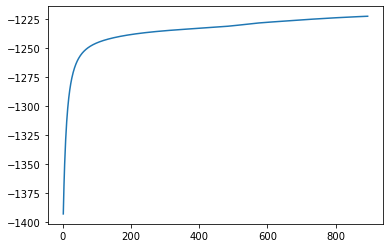

In [593]:
# parameters for EM loop: threshold, max_iter, gamma
par = parEM(1e-5, int(5000), 0.1)  

Res = dfm(y, X_mean, X_std, M, S, spec, blocks, par, 'res_t5')

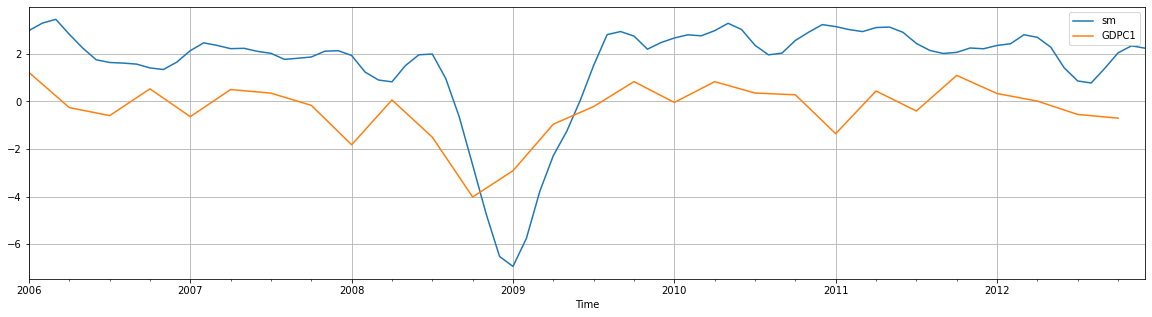

In [595]:
x_sm, x_tr = get_smoothed('res_t5', 'GDPC1', ['Global', 'Soft', 'Real', 'Labor'])

fig, axs = plt.subplots(1, 1, figsize=(20, 5))

x_sm.loc['2006':'2012'].plot(ax=axs, label='sm')
x_tr.loc['2006':'2012'].plot(ax=axs)
axs.grid()
axs.legend()

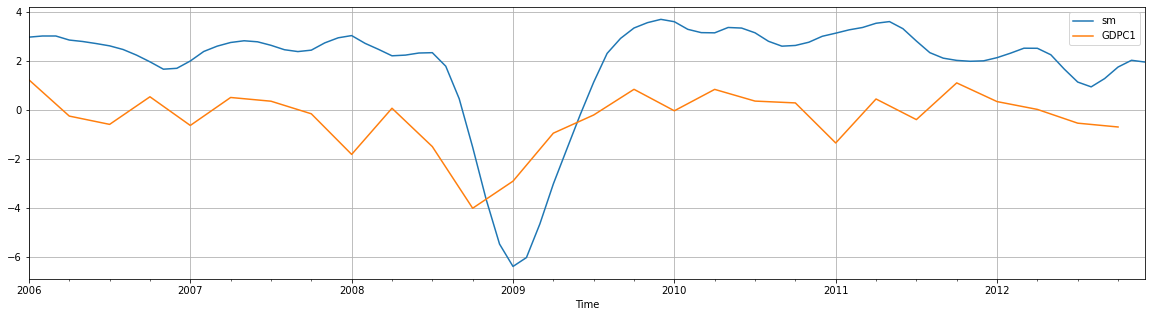

In [596]:
x_sm, x_tr = get_smoothed('res_t5', 'GDPC1', ['Global'])

fig, axs = plt.subplots(1, 1, figsize=(20, 5))

x_sm.loc['2006':'2012'].plot(ax=axs, label='sm')
x_tr.loc['2006':'2012'].plot(ax=axs)
axs.grid()
axs.legend()

# Update nowcast

In [ ]:
Res = DFMResult(**pickle.load(open('res_t5',"rb")))

In [282]:
# User input.
series = 'GDPC1'   # Nowcasting real GDP (GDPC1) <fred.stlouisfed.org/series/GDPC1>
period = '2016q4'  # Forecasting target quarter. For monthly variable, '2016-10-1' or '2016-10'

# Update nowcast and decompose nowcast changes into news.

### Nowcast update from week of December 7 to week of December 16, 2016 ###
vintage_old = '2016-12-16'
datafile_old = path.join('data', country, vintage_old + '.xls')
vintage_new = '2016-12-23'
datafile_new = path.join('data', country, vintage_new + '.xls')

# Load datasets for each vintage
Xn_old, Mx_old, Wx_old, X_old, X_data_old = load_data(datafile_old, spec);
Xn_new, Mx_new, Wx_new, X_new, X_data_new = load_data(datafile_new, spec);

In [284]:
# update_nowcast(X_old,X_new,Time,Spec,Res,series,period,vintage_old,vintage_new);

NameError: name 'update_nowcast' is not defined

In [ ]:
# Make sure datasets are the same size
T, N = X_new.shape

# append 1 year (12 months) of data to each dataset to allow for
# forecasting at different horizons

fps = pd.date_range(X_new.index[0], X_new.index[-1] + MonthBegin(12), freq=X_new.index.freq)

X_new = X_new.reindex(fps)
X_old = X_old.reindex(fps)

series_name = spec.SeriesName.loc[series]
freq        = spec.Frequency.loc[series]

if freq=='q':
    t_nowcast = pd.to_datetime(period) + MonthBegin(2)
elif freq=='m':
    t_nowcast = pd.to_datetime(period)

if t_nowcast not in X_new.index:
    print('Period is out of nowcasting horizon (up to one year ahead).')
    sys.exit(1)

# Update nowcast for target variable 'series' (i) at horizon 'period' (t)
#   > Relate nowcast update into news from data releases:
#     a. Compute the impact from data revisions
#     b. Compute the impact from new data releases

X_rev = X_new.copy()
X_rev[X_old.isnull()] = np.nan

In [296]:
X_old = X_rev.copy()
t_fcst = t_nowcast
v_news = series

In [ ]:
# Compute news

# Compute impact from data revisions
y_old = News_DFM(X_old, X_rev, Res, t_nowcast, i_series)

# # Compute impact from data releases
# y_rev, y_new, ~, actual, forecast, weight = News_DFM(X_rev, X_new, Res, t_nowcast, i_series)

### News_DFM

In [297]:
# def News_DFM(X_old, X_new, Res, t_fcst, v_news):
#News_DFM()    Calculates changes in news
#             
#  Syntax:
#  [y_old, y_new, singlenews, actual, fore, weight ,t_miss, v_miss, innov] = ...
#    News_DFM(X_old, X_new, Q, t_fcst, v_news) 
#
#  Description:
#   News DFM() inputs two datasets, DFM parameters, target time index, and 
#   target variable index. The function then produces Nowcast updates and
#   decomposes the changes into news.
#
#  Input Arguments:
#    X_old:  Old data matrix (old vintage)
#    X_new:  New data matrix (new vintage)
#    Res:    DFM() output results (see DFM for more details)
#    t_fcst: Index for target time
#    v_news: Index for target variable 
#
#  Output Arguments:
#    y_old:       Old nowcast
#    y_new:       New nowcast
#    single_news: News for each data series
#    actual:      Observed series release values
#    fore:        Forecasted series values
#    weight:      News weight
#    t_miss:      Time index for data releases
#    v_miss:      Series index for data releases
#    innov:       Difference between observed and predicted series values ("innovation")

## Initialize variables
r = Res.M.C.shape[1]         # number of factors
T, N = X_new.shape
singlenews = np.zeros((1,N)) # Initialize news vector (will store news for each series)

In [ ]:
## NO FORECAST CASE: value for v_news at t_fcst exists
if ~X_new.loc[t_fcst, v_news].isnull():
    
    Res_old = para_const(X_old, Res, 0)  # Apply Kalman filter for old data
    

    for i=1:size(v_news,2)      # Loop for each target variable
        # (Observed value) - (predicted value)
        singlenews(:,v_news(i)) = X_new(t_fcst,v_news(i)) ...
                                    - Res_old.X_sm(t_fcst,v_news(i));
        
        # Set predicted and observed y values
        y_old(1,i) = Res_old.X_sm(t_fcst,v_news(i));
        y_new(1,i) = X_new(t_fcst,v_news(i));
    end
    
    # Forecast-related output set to empty
    actual=[];forecast=[];weight=[];t_miss=[];v_miss=[];innov=[];

In [ ]:
## FORECAST CASE (these are broken down into (A) and (B))
else:    

In [299]:
    # Initialize series mean/standard deviation respectively
    Mx = Res.Mx
    Wx = Res.Wx
    

In [300]:
    # Calculate indicators for missing values (1 if missing, 0 otherwise)
    miss_old = X_old.isnull()
    miss_new = X_new.isnull()

In [304]:
    # Indicator for missing--combine above information to single matrix where:
    # (i) -1: Value is in the old data, but missing in new data
    # (ii) 1: Value is in the new data, but missing in old data 
    # (iii) 0: Values are missing from/available in both datasets
    i_miss = miss_old.astype(int) - miss_new.astype(int)

In [307]:
    # Time/variable indicies where case (b) is true
    miss = (i_miss==1)

In [ ]:
    
    ## FORECAST SUBCASE (A): NO NEW INFORMATION
    
    if isempty(v_miss)
        # Fill in missing variables using a Kalman filter
        Res_old = para_const(X_old, Res, 0);
        Res_new = para_const(X_new, Res, 0);
        
        # Set predicted and observed y values. New y value is set to old
        y_old = Res_old.X_sm(t_fcst,v_news);
        y_new = y_old;
        # y_new = Res_new.X_sm(t_fcst,v_news);
        
        # No news, so nothing returned for news-related output
        groupnews=[];singlenews=[];gain=[];gainSer=[];
        actual=[];forecast=[];weight=[];t_miss=[];v_miss=[];innov=[];
    else
    #----------------------------------------------------------------------
    #     v_miss=[1:size(X_new,2)]';
    #     t_miss=t_miss(1)*ones(size(X_new,2),1);
    #----------------------------------------------------------------------
    ## FORECAST SUBCASE (B): NEW INFORMATION
   
    # Difference between forecast time and new data time
    lag = t_fcst-t_miss;
    
    # Gives biggest time interval between forecast and new data
    k = max([abs(lag); max(lag)-min(lag)]);
    
    C = Res.C;   # Observation matrix
    R = Res.R';  # Covariance for observation matrix residuals
    
    # Number of new events
    n_news = size(lag,1);
    
    # Smooth old dataset
    Res_old = para_const(X_old, Res, k);
    Plag = Res_old.Plag;
    
    # Smooth new dataset
    Res_new = para_const(X_new, Res, 0);
    
    # Subset for target variable and forecast time
    y_old = Res_old.X_sm(t_fcst,v_news);
    y_new = Res_new.X_sm(t_fcst,v_news);
    
    
    
    P = Res_old.P(:,:,2:end);
    P1=[];  # Initialize projection onto updates
    
    # Cycle through total number of updates
    for i=1:n_news
        h = abs(t_fcst-t_miss(i));
        m = max([t_miss(i) t_fcst]);
        
        # If location of update is later than the forecasting date
        if t_miss(i)>t_fcst
            Pp=Plag{h+1}(:,:,m);  #P(1:r,h*r+1:h*r+r,m)';
        else
            Pp=Plag{h+1}(:,:,m)';  #P(1:r,h*r+1:h*r+r,m);
        end
        P1=[P1 Pp*C(v_miss(i),1:r)'];  # Projection on updates
    end
    
    for i=1:size(t_miss,1)
        # Standardize predicted and observed values
        X_new_norm = (X_new(t_miss(i),v_miss(i)) - Mx(v_miss(i)))./Wx(v_miss(i));
        X_sm_norm = (Res_old.X_sm(t_miss(i),v_miss(i))- Mx(v_miss(i)))./Wx(v_miss(i));
        
        # Innovation: Gives [observed] data - [predicted data]
        innov(i)= X_new_norm - X_sm_norm;          
    end
    
    ins=size(innov,2);
    P2=[];
    p2=[];
    
    # Gives non-standardized series weights
    for i=1:size(lag,1)
        for j=1:size(lag,1)
            h=abs(lag(i)-lag(j));
            m=max([t_miss(i),t_miss(j)]);
            
            if t_miss(j)>t_miss(i)
                Pp=Plag{h+1}(:,:,m); #P(1:r,h*r+1:(h+1)*r,m)';
            else
                Pp=Plag{h+1}(:,:,m)'; #P(1:r,h*r+1:(h+1)*r,m);
            end
            if v_miss(i)==v_miss(j) & t_miss(i)~=t_miss(j)
                WW(v_miss(i),v_miss(j))=0;
            else
                WW(v_miss(i),v_miss(j))=R(v_miss(i),v_miss(j));
            end
            p2=[p2 C(v_miss(i),1:r)*Pp*C(v_miss(j),1:r)'+WW(v_miss(i),v_miss(j))];
        end
        P2=[P2;p2];
        p2=[];
    end
    
    clear temp
    for i=1:size(v_news,2)      # loop on v_news
        # Convert to real units (unstadardized data)
        totnews(1,i) = Wx(v_news(i))*C(v_news(i),1:r)*P1*inv(P2)*innov';
        temp(1,:,i) = Wx(v_news(i))*C(v_news(i),1:r)*P1*inv(P2).*innov;
        gain(:,:,i) = Wx(v_news(i))*C(v_news(i),1:r)*P1*inv(P2);
    end
    
    # Initialize output objects
    singlenews = NaN(max(t_miss)-min(t_miss)+1,N); #,size(v_news,2)
    actual     = NaN(N,1);  # Actual forecasted values
    forecast   = NaN(N,1);  # Forecasted values
    weight     = NaN(N,1,size(v_news,2));
    
    # Fill in output values 
    for i=1:size(innov,2)
        actual(v_miss(i),1) = X_new(t_miss(i),v_miss(i));  
        forecast(v_miss(i),1) = Res_old.X_sm(t_miss(i),v_miss(i));
        
        for j=1:size(v_news,2)
            singlenews(t_miss(i)-min(t_miss)+1,v_miss(i),j) = temp(1,i,j);
            weight(v_miss(i),:,j) = gain(:,i,j)/Wx(v_miss(i));
        end
    end
    
    singlenews = sum(singlenews,1);      # Returns total news

    
    [v_miss, ~, ~] = unique(v_miss);  
    
end

end

end
                
return y_old, y_new, singlenews, actual, forecast, weight, t_miss, v_miss, innov

### para_const

In [364]:
def para_const(X, Res, lag):
    #para_const()    Implements Kalman filter for "News_DFM.m"
    #
    #  Syntax:
    #    Res = para_const(X,P,lag)
    #
    #  Description:
    #    para_const() implements the Kalman filter for the news calculation
    #    step. This procedure smooths and fills in missing data for a given 
    #    data matrix X. In contrast to runKF(), this function is used when
    #    model parameters are already estimated.
    #
    #  Input parameters:
    #    X: Data matrix. 
    #    P: Parameters from the dynamic factor model.
    #    lag: Number of lags
    #
    #  Output parameters:
    #    Res [struc]: A structure containing the following:
    #      Res.Plag: Smoothed factor covariance for transition matrix
    #      Res.P:    Smoothed factor covariance matrix
    #      Res.X_sm: Smoothed data matrix
    #      Res.F:    Smoothed factors
    #    


    # Kalman filter with specified paramaters 
    # written for 
    # "MAXIMUM LIKELIHOOD ESTIMATION OF FACTOR MODELS ON DATA SETS WITH
    # ARBITRARY PATTERN OF MISSING DATA."
    # by Marta Banbura and Michele Modugno 

    ## Set model parameters and data preparation

    # Set model parameters
    A, C, Q, R, Z_0, V_0 = Res.M
    Mx = Res.Mx
    Wx = Res.Wx
    
    C_df = C.copy()

    # Prepare data
    T, N = X.shape

    # Standardise x by means and s.e. from DFM module
    Y = ((X - Mx)/Wx).T
    
    
    states = pd.MultiIndex.from_tuples(A.index)
    ps = Y.columns
    ps_0 = pd.date_range(ps[0] - MonthBegin(), ps[-1], freq=ps.freq)
    
    ps_states = pd.MultiIndex.from_tuples([(i, j, p, q) 
                                                for i in ps for j, p, q in states.to_flat_index()])
    ps_0_states = pd.MultiIndex.from_tuples([(i, j, p, q) 
                                                  for i in ps_0 for j, p, q in states.to_flat_index()])
    
    
    Y, A, C, Q, R = Y.to_numpy(), A.to_numpy(), C.to_numpy(), Q.to_numpy(), R.to_numpy()
    Z_0, V_0 = Z_0.to_numpy(), V_0.to_numpy()

    ## Apply Kalman filter and smoother
    # See runKF() for details about FIS and SKF
    Zm, ZmU, Vm, VmU, loglik, k_t = SKF(Y, A, C, Q, R, Z_0, V_0)   # Kalman filter
    ZmT, VmT, VmT_1 = FIS(A, Zm, ZmU, Vm, VmU, loglik, k_t)        # Fixed interval smoother

    # Sf = SKF(Y, A, C, Q, R, Z_0, V_0);  # Kalman filter
    # Ss = FIS(A, Sf);  # Smoothing step

    ## Calculate parameter output
    Vs = VmT[1:, :, :].copy()  # ?? not used... Smoothed factor covariance for transition matrix
    Vf = VmU[1:, :, :].copy()  # Filtered factor posterior covariance
    Zsmooth = ZmT.copy()       # Smoothed factors
    Vsmooth = VmT.copy()       # Smoothed covariance values
    

    Plag = {0:Vs}
    for jk in range(1, lag+1):
        pl = np.zeros(Vs.shape)
        for pl_j, Vf_j, Plag_j in zip(pl[-(pl.shape[0]-lag):], Vf[-(pl.shape[0]-lag)-jk:-jk], 
                                      Plag[jk-1][-(pl.shape[0]-lag):]):
            As = Vf_j.dot(A.T).dot(pinv(A.dot(Vf_j).dot(A.T) + Q))
            pl_j[:, :] = As.dot(Plag_j)
        Plag[jk] = pl


    # Prepare data for output
    F = pd.DataFrame(Zsmooth[1:, :], index=ps, columns=states)
    
    X_sm = F.dot(C_df.T) * Wx + Mx  # Standardized to unstandardized
    P = Vsmooth.copy()

    #--------------------------------------------------------------------------
    #   Loading the structure with the results
    #--------------------------------------------------------------------------
    return Plag, P, X_sm, F

In [365]:
Plag, P, X_sm, F = para_const(X_new, Res, 0)

In [371]:
Res.M.C

Global                                          \
                           0         1         2         3         4   
                           1         1         1         1         1   
SeriesID                                                               
PAYEMS              0.252550  0.000000  0.000000  0.000000  0.000000   
JTSJOL              0.094813  0.000000  0.000000  0.000000  0.000000   
CPIAUCSL            0.249394  0.000000  0.000000  0.000000  0.000000   
DGORDER             0.122920  0.000000  0.000000  0.000000  0.000000   
RSAFS               0.217667  0.000000  0.000000  0.000000  0.000000   
UNRATE             -0.187400  0.000000  0.000000  0.000000  0.000000   
HOUST               0.104511  0.000000  0.000000  0.000000  0.000000   
INDPRO              0.248418  0.000000  0.000000  0.000000  0.000000   
DSPIC96            -0.005896  0.000000  0.000000  0.000000  0.000000   
BOPTEXP             0.277830  0.000000  0.000000  0.000000  0.000000   
BOPTIMP             0.272499  0.000000  0.000000  0.000000  0.000000   
TTLCONS             0.127589  0.000000  0.000000  0.000000  0.000000   
IR                  0.281671  0.000000  0.000000  0.000000  0.000000   
CPILFESL            0.037023  0.000000  0.000000  0.000000  0.000000   
PCEPILFE            0.126205  0.000000  0.000000  0.000000  0.000000   
PCEPI               0.272452  0.000000  0.000000  0.000000  0.000000   
PERMIT              0.095337  0.000000  0.000000  0.000000  0.000000   
TCU                 0.246310  0.000000  0.000000  0.000000  0.000000   
BUSINV              0.261068  0.000000  0.000000  0.000000  0.000000   
IQ                  0.260199  0.000000  0.000000  0.000000  0.000000   
GACDISA066MSFRBNY   0.249907  0.000000  0.000000  0.000000  0.000000   
PCEC96              0.135343  0.000000  0.000000  0.000000  0.000000   
GACDFSA066MSFRBPHI  0.262381  0.000000  0.000000  0.000000  0.000000   
GDPC1               0.033715  0.067430  0.101144  0.067430  0.033715   
ULCNFB             -0.000803 -0.001607 -0.002410 -0.001607 -0.000803   

                        Soft                      ... GDPC1                 \
                           0    1    2    3    4  ...     0    1    2    3   
                           1    1    1    1    1  ...     1    1    1    1   
SeriesID                                          ...                        
PAYEMS              0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
JTSJOL              0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
CPIAUCSL            0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
DGORDER             0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
RSAFS               0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
UNRATE              0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
HOUST               0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
INDPRO              0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
DSPIC96             0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
BOPTEXP             0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
BOPTIMP             0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
TTLCONS             0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
IR                  0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
CPILFESL            0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
PCEPILFE            0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
PCEPI               0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
PERMIT              0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
TCU                 0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
BUSINV              0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
IQ                  0.000000  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0   
GACDISA066MSFRBNY   0.668387  0.0  0.0  0.0  0.0  ...   0.0  

In [366]:
F

Global                                              Soft  \
                   0         1         2         3         4         0   
                   1         1         1         1         1         1   
2000-01-01  0.343747  0.153424 -0.945192 -0.674445 -0.481253  0.419103   
2000-02-01  1.665188  0.343747  0.153424 -0.945192 -0.674445  0.348546   
2000-03-01  2.279275  1.665188  0.343747  0.153424 -0.945192  0.392737   
2000-04-01  0.059136  2.279275  1.665188  0.343747  0.153424  0.354484   
2000-05-01  0.675246  0.059136  2.279275  1.665188  0.343747  0.316347   
...              ...       ...       ...       ...       ...       ...   
2017-08-01  0.084146  0.101162  0.121619  0.146212  0.175779  0.170291   
2017-09-01  0.069992  0.084146  0.101162  0.121619  0.146212  0.143193   
2017-10-01  0.058219  0.069992  0.084146  0.101162  0.121619  0.120406   
2017-11-01  0.048426  0.058219  0.069992  0.084146  0.101162  0.101245   
2017-12-01  0.040281  0.048426  0.058219  0.069992  0.084146  0.085134   

                                                    ...         GDPC1  \
                   1         2         3         4  ...             0   
                   1         1         1         1  ...             1   
2000-01-01  0.484526  0.285474  0.168197  0.099099  ... -6.440430e-02   
2000-02-01  0.419103  0.484526  0.285474  0.168197  ...  9.011014e-02   
2000-03-01  0.348546  0.419103  0.484526  0.285474  ...  2.435461e-01   
2000-04-01  0.392737  0.348546  0.419103  0.484526  ...  3.923855e-01   
2000-05-01  0.354484  0.392737  0.348546  0.419103  ...  1.921767e-01   
...              ...       ...       ...       ...  ...           ...   
2017-08-01  0.202519  0.240845  0.286424  0.340629  ...  6.551798e-23   
2017-09-01  0.170291  0.202519  0.240845  0.286424  ...  8.602879e-25   
2017-10-01  0.143193  0.170291  0.202519  0.240845  ...  1.129606e-26   
2017-11-01  0.120406  0.143193  0.170291  0.202519  ...  1.483237e-28   
2017-12-01  0.101245  0.120406  0.143193  0.170291  ...  1.947573e-30   

                                                                    \
                       1             2             3             4   
                       1             1             1             1   
2000-01-01 -2.964688e-01 -9.018399e-02  5.553724e-02 -8.006501e-03   
2000-02-01 -6.440430e-02 -2.964688e-01 -9.018399e-02  5.553724e-02   
2000-03-01  9.011014e-02 -6.440430e-02 -2.964688e-01 -9.018399e-02   
2000-04-01  2.435461e-01  9.011014e-02 -6.440430e-02 -2.964688e-01   
2000-05-01  3.923855e-01  2.435461e-01  9.011014e-02 -6.440430e-02   
...                  ...           ...           ...           ...   
2017-08-01  4.989732e-21  3.800090e-19  2.894080e-17  2.204080e-15   
2017-09-01  6.551798e-23  4.989732e-21  3.800090e-19  2.894080e-17   
2017-10-01  8.602879e-25  6.551798e-23  4.989732e-21  3.800090e-19   
2017-11-01  1.129606e-26  8.602879e-25  6.551798e-23  4.989732e-21   
2017-12-01  1.483237e-28  1.129606e-26  8.602879e-25  6.551798e-23   

                  ULCNFB                                            \
                       0             1             2             3   
                       1             1             1             1   
2000-01-01  1.967127e-01  9.684405e-01  2.755865e-01 -2.014161e-01   
2000-02-01  3.817373e-02  1.967127e-01  9.684405e-01  2.755865e-01   
2000-03-01 -1.562348e-01  3.817373e-02  1.967127e-01  9.684405e-01   
2000-04-01 -3.773165e-01 -1.562348e-01  3.817373e-02  1.967127e-01   
2000-05-01 -1.263852e-01 -3.773165e-01 -1.562348e-01  3.817373e-02   
...                  ...           ...           ...           ...   
2017-08-01  8.925073e-16 -1.453893e-14  2.368388e-13 -3.858100e-12   
2017-09-01 -5.478873e-17  8.925073e-16 -1.453893e-14  2.368388e-13   
2017-10-01  3.363339e-18 -5.478873e-17  8.925073e-16 -1.453893e-14   
2017-11-01 -2.064667e-19  3.363339e-18 -5.478873e-17  8.925073e-16   
2017-12-01  1.267446e-20 -2.064667e-19  3.363339e-18 -5.478873e

In [240]:
Res._fields

('x_sm', 'X_sm', 'Mx', 'Wx', 'Z', 'r', 'p', 'M', 'spec', 'blocks')

In [226]:
aa = np.ones((5, 2, 2))
bb = np.ones((5, 2, 2))
cc = np.random.randint(1, 10, 20).reshape((5, 2, 2))

In [237]:
Plag = {0: np.eye(2)}

A = np.eye(2)
Q = np.diag([1, 2])
lag = 3
for jk in range(1, lag+1):
    pl = np.zeros(cc.shape)
    for pl_j, Vf_j, Plag_j in zip(pl[-(pl.shape[0]-lag):], cc[-(pl.shape[0]-lag)-jk:-jk], Plag[jk-1][-(pl.shape[0]-lag):]):
        As = Vf_j.dot(A.T).dot(pinv(A.dot(Vf_j).dot(A.T) + Q))
        pl_j[:, :] = As.dot(Plag_j)
    Plag[jk] = pl

In [239]:
pl

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.78864971,  0.12720157],
        [ 0.5611546 ,  0.09050881]],

       [[ 0.45396825, -0.22698413],
        [ 0.32222222, -0.16111111]]])

In [238]:
Plag

{0: array([[1., 0.],
        [0., 1.]]),
 1: array([[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.88571429,  0.14285714],
         [ 0.88571429,  0.14285714]],
 
        [[ 0.5       , -0.25      ],
         [ 0.5       , -0.25      ]]]),
 2: array([[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.88571429,  0.14285714],
         [ 0.66428571,  0.10714286]],
 
        [[ 0.45714286, -0.22857143],
         [ 0.42857143, -0.21428571]]]),
 3: array([[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.        ,  0.

In [235]:
for a, b, c in zip(aa[-(5-lag):], bb[-(5-lag):], cc[-(5-lag):]):
    print(a[:], b, c)

[[1. 1.]
 [1. 1.]] [[1. 1.]
 [1. 1.]] [[9 8]
 [8 6]]
[[1. 1.]
 [1. 1.]] [[1. 1.]
 [1. 1.]] [[6 4]
 [9 5]]


In [227]:
cc

array([[[6, 4],
        [1, 9]],

       [[9, 8],
        [1, 6]],

       [[9, 2],
        [5, 6]],

       [[9, 8],
        [8, 6]],

       [[6, 4],
        [9, 5]]])

In [221]:
cc

array([1, 1, 0])

In [194]:
bb = np.eye(11)

In [217]:
for bb_j in bb[-(bb.shape[0]-lag):]:
    bb_j[:] = np.random.randint(11)
    print(bb_j)

[7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
[8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [218]:
bb

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.],
       [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]])

In [782]:
Am = pd.read_csv('Am.csv', header=None).to_numpy()
Am = pd.DataFrame(Am, index=A.index, columns=A.columns)
Cm = pd.read_csv('Cm.csv', header=None).to_numpy()
Cm = pd.DataFrame(Cm, index=C.index, columns=C.columns)
Qm = pd.read_csv('Qm.csv', header=None).to_numpy()
Qm = pd.DataFrame(Qm, index=Q.index, columns=Q.columns)
Rm = pd.read_csv('Rm.csv', header=None).to_numpy()
Rm = pd.DataFrame(Rm, index=R.index, columns=R.columns)
V_0m = pd.read_csv('V_0m.csv', header=None).to_numpy()
V_0m = pd.DataFrame(V_0m, index=V_0.index, columns=V_0.columns)
Z_0m = pd.read_csv('Z_0m.csv', header=None).to_numpy().squeeze()
Z_0m = pd.Series(Z_0m, index=Z_0.index)

# Python 과 Matlab 비교

## InitCond(): 최대 0.004% 수준

In [34]:
M = InitCond(X_norm, S, spec, blocks, optNaN_init)

In [36]:
Am = pd.read_csv('A_init.csv', header=None).to_numpy()
Am = pd.DataFrame(Am, index=M.A.index, columns=M.A.columns)
Cm = pd.read_csv('C_init.csv', header=None).to_numpy()
Cm = pd.DataFrame(Cm, index=M.C.index, columns=M.C.columns)
Qm = pd.read_csv('Q_init.csv', header=None).to_numpy()
Qm = pd.DataFrame(Qm, index=M.Q.index, columns=M.Q.columns)
Rm = pd.read_csv('R_init.csv', header=None).to_numpy()
Rm = pd.DataFrame(Rm, index=M.R.index, columns=M.R.columns)
V_0m = pd.read_csv('V_0_init.csv', header=None).to_numpy()
V_0m = pd.DataFrame(V_0m, index=M.V_0.index, columns=M.V_0.columns)
Z_0m = pd.read_csv('Z_0_init.csv', header=None).to_numpy().squeeze()
Z_0m = pd.Series(Z_0m, index=M.Z_0.index)

<AxesSubplot:>

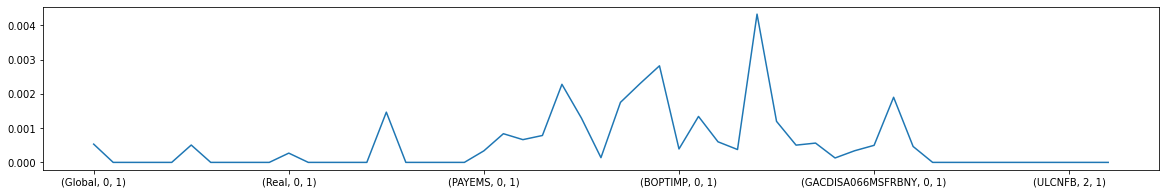

In [43]:
(abs(M.A-Am).sum(axis=1) / abs(M.A).sum(axis=1) * 100).plot(figsize=(20, 3))

In [45]:
qd = abs(M.A-Am).stack(level=[0,1,2]).nlargest(20)
qd / M.A.stack(level=[0,1,2]).loc[qd.index] * 100

Labor               0  1  Labor               0  1    0.001466
PCEPILFE            0  1  PCEPILFE            0  1   -0.004327
DSPIC96             0  1  DSPIC96             0  1   -0.002297
BOPTEXP             0  1  BOPTEXP             0  1   -0.002818
PCEPI               0  1  PCEPI               0  1    0.001197
Global              0  1  Global              0  1    0.000533
TTLCONS             0  1  TTLCONS             0  1    0.001341
PCEC96              0  1  PCEC96              0  1   -0.001900
DGORDER             0  1  DGORDER             0  1   -0.000785
UNRATE              0  1  UNRATE              0  1   -0.001292
Soft                0  1  Soft                0  1    0.000507
IR                  0  1  IR                  0  1    0.000601
JTSJOL              0  1  JTSJOL              0  1   -0.000837
RSAFS               0  1  RSAFS               0  1   -0.002278
CPIAUCSL            0  1  CPIAUCSL            0  1    0.000664
GACDFSA066MSFRBPHI  0  1  GACDFSA066MSFRBPHI  0  1    0

In [46]:
qd

Labor               0  1  Labor               0  1    4.980541e-06
PCEPILFE            0  1  PCEPILFE            0  1    4.969258e-06
DSPIC96             0  1  DSPIC96             0  1    4.749506e-06
BOPTEXP             0  1  BOPTEXP             0  1    4.425375e-06
PCEPI               0  1  PCEPI               0  1    3.954019e-06
Global              0  1  Global              0  1    3.802251e-06
TTLCONS             0  1  TTLCONS             0  1    3.778350e-06
PCEC96              0  1  PCEC96              0  1    3.610369e-06
DGORDER             0  1  DGORDER             0  1    3.210121e-06
UNRATE              0  1  UNRATE              0  1    3.161593e-06
Soft                0  1  Soft                0  1    2.985169e-06
IR                  0  1  IR                  0  1    2.795810e-06
JTSJOL              0  1  JTSJOL              0  1    2.777405e-06
RSAFS               0  1  RSAFS               0  1    2.336868e-06
CPIAUCSL            0  1  CPIAUCSL            0  1    2.222034

<AxesSubplot:xlabel='SeriesID'>

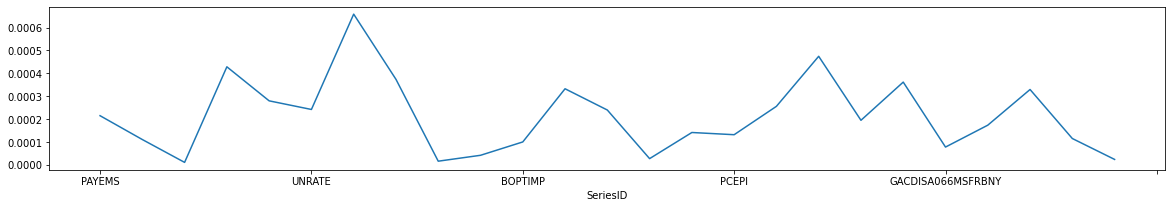

In [40]:
(abs(M.C-Cm).sum(axis=1) / abs(M.C).sum(axis=1) * 100).plot(figsize=(20, 3))

In [42]:
qd

SeriesID                        
HOUST               Real    0  1    0.000005
IQ                  Global  0  1    0.000005
HOUST               Global  0  1    0.000004
DGORDER             Global  0  1    0.000004
TCU                 Global  0  1    0.000004
GACDFSA066MSFRBPHI  Global  0  1    0.000004
PAYEMS              Labor   0  1    0.000004
UNRATE              Labor   0  1    0.000004
GDPC1               Real    3  1    0.000004
                            1  1    0.000004
PERMIT              Real    0  1    0.000004
TTLCONS             Real    0  1    0.000004
IR                  Global  0  1    0.000003
INDPRO              Real    0  1    0.000003
RSAFS               Real    0  1    0.000003
TCU                 Real    0  1    0.000003
PCEC96              Global  0  1    0.000002
GACDFSA066MSFRBPHI  Soft    0  1    0.000002
BUSINV              Global  0  1    0.000002
INDPRO              Global  0  1    0.000002
dtype: float64

In [41]:
qd = abs(M.C-Cm).stack(level=[0,1,2]).nlargest(20)
qd / M.C.stack(level=[0,1,2]).loc[qd.index] * 100

SeriesID                        
HOUST               Real    0  1    0.001661
IQ                  Global  0  1    0.001752
HOUST               Global  0  1    0.004231
DGORDER             Global  0  1    0.003590
TCU                 Global  0  1    0.001690
GACDFSA066MSFRBPHI  Global  0  1    0.001585
PAYEMS              Labor   0  1    0.000670
UNRATE              Labor   0  1   -0.000565
GDPC1               Real    3  1    0.003506
                            1  1    0.003506
PERMIT              Real    0  1    0.000957
TTLCONS             Real    0  1    0.001196
IR                  Global  0  1    0.001091
INDPRO              Real    0  1   -0.001907
RSAFS               Real    0  1    0.000594
TCU                 Real    0  1   -0.001497
PCEC96              Global  0  1    0.001842
GACDFSA066MSFRBPHI  Soft    0  1    0.000329
BUSINV              Global  0  1    0.000917
INDPRO              Global  0  1    0.000913
dtype: float64

<AxesSubplot:>

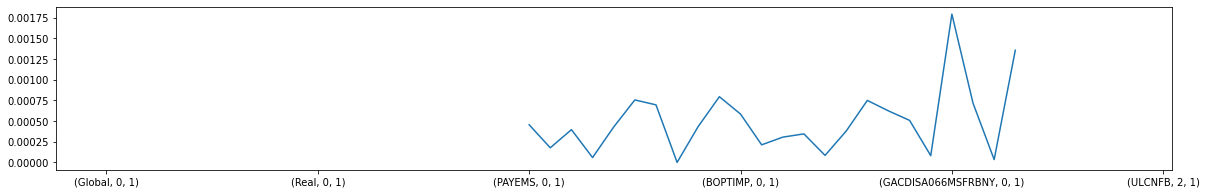

In [47]:
(abs(M.Q-Qm).sum(axis=1) / abs(M.Q).sum(axis=1) * 100).plot(figsize=(20, 3))

In [48]:
qd = abs(M.Q-Qm).stack(level=[0,1,2]).nlargest(20)
qd / M.Q.stack(level=[0,1,2]).loc[qd.index] * 100

Real               0  1  Real               0  1    0.001555
PERMIT             0  1  PERMIT             0  1    0.000750
Soft               0  1  Soft               0  1    0.000792
HOUST              0  1  HOUST              0  1    0.000696
DSPIC96            0  1  DSPIC96            0  1    0.000435
BOPTEXP            0  1  BOPTEXP            0  1    0.000794
TCU                0  1  TCU                0  1    0.000623
CPILFESL           0  1  CPILFESL           0  1    0.000345
PCEC96             0  1  PCEC96             0  1    0.000717
BOPTIMP            0  1  BOPTIMP            0  1    0.000585
UNRATE             0  1  UNRATE             0  1    0.000756
CPIAUCSL           0  1  CPIAUCSL           0  1    0.000396
GACDISA066MSFRBNY  0  1  GACDISA066MSFRBNY  0  1    0.001793
BUSINV             0  1  BUSINV             0  1    0.000508
PCEPI              0  1  PCEPI              0  1    0.000379
TTLCONS            0  1  TTLCONS            0  1    0.000213
RSAFS              0  1 

In [49]:
qd

Real               0  1  Real               0  1    0.000026
PERMIT             0  1  PERMIT             0  1    0.000004
Soft               0  1  Soft               0  1    0.000004
HOUST              0  1  HOUST              0  1    0.000004
DSPIC96            0  1  DSPIC96            0  1    0.000004
BOPTEXP            0  1  BOPTEXP            0  1    0.000004
TCU                0  1  TCU                0  1    0.000004
CPILFESL           0  1  CPILFESL           0  1    0.000003
PCEC96             0  1  PCEC96             0  1    0.000003
BOPTIMP            0  1  BOPTIMP            0  1    0.000003
UNRATE             0  1  UNRATE             0  1    0.000002
CPIAUCSL           0  1  CPIAUCSL           0  1    0.000002
GACDISA066MSFRBNY  0  1  GACDISA066MSFRBNY  0  1    0.000002
BUSINV             0  1  BUSINV             0  1    0.000002
PCEPI              0  1  PCEPI              0  1    0.000002
TTLCONS            0  1  TTLCONS            0  1    0.000002
RSAFS              0  1 

<AxesSubplot:>

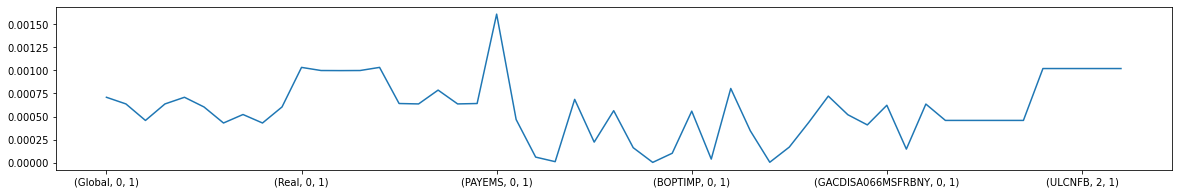

In [50]:
(abs(M.V_0-V_0m).sum(axis=1) / abs(M.V_0).sum(axis=1) * 100).plot(figsize=(20, 3))

In [51]:
qd = abs(M.V_0-V_0m).stack(level=[0,1,2]).nlargest(20)
qd / M.V_0.stack(level=[0,1,2]).loc[qd.index] * 100

Global  0  1  Global  3  1    0.002002
        1  1  Global  4  1    0.002002
        3  1  Global  0  1    0.002002
        4  1  Global  1  1    0.002002
        0  1  Global  1  1    0.000683
        1  1  Global  0  1    0.000683
                      2  1    0.000683
        2  1  Global  1  1    0.000683
                      3  1    0.000683
        3  1  Global  2  1    0.000683
                      4  1    0.000683
        4  1  Global  3  1    0.000683
        0  1  Global  4  1    0.001555
        4  1  Global  0  1    0.001555
Real    0  1  Real    0  1    0.001071
        1  1  Real    1  1    0.001071
        2  1  Real    2  1    0.001071
        3  1  Real    3  1    0.001071
        4  1  Real    4  1    0.001071
Global  0  1  Global  2  1    0.000403
dtype: float64

In [52]:
qd

Global  0  1  Global  3  1    0.000046
        1  1  Global  4  1    0.000046
        3  1  Global  0  1    0.000046
        4  1  Global  1  1    0.000046
        0  1  Global  1  1    0.000031
        1  1  Global  0  1    0.000031
                      2  1    0.000031
        2  1  Global  1  1    0.000031
                      3  1    0.000031
        3  1  Global  2  1    0.000031
                      4  1    0.000031
        4  1  Global  3  1    0.000031
        0  1  Global  4  1    0.000026
        4  1  Global  0  1    0.000026
Real    0  1  Real    0  1    0.000018
        1  1  Real    1  1    0.000018
        2  1  Real    2  1    0.000018
        3  1  Real    3  1    0.000018
        4  1  Real    4  1    0.000018
Global  0  1  Global  2  1    0.000013
dtype: float64

## y_est: 최대 0.001%

In [53]:
y_est = remNaNs_spline(X_norm, optNaN_em)[0].T

In [54]:
y_estm = pd.read_csv('y_est.csv', header=None).to_numpy()
y_estm = pd.DataFrame(y_estm, index=y_est.index, columns=y_est.columns)

<AxesSubplot:xlabel='SeriesID'>

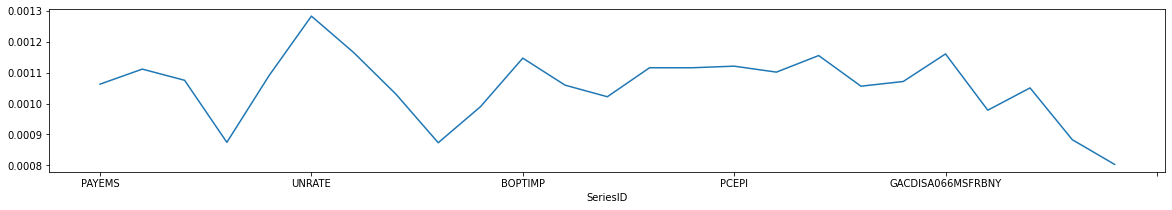

In [55]:
(abs(y_est-y_estm).sum(axis=1) / abs(y_est).sum(axis=1) * 100).plot(figsize=(20, 3))

In [57]:
abs(y_est-y_estm).stack().nlargest(15)

SeriesID           Time      
HOUST              2002-09-01    0.000050
JTSJOL             2004-07-01    0.000050
HOUST              2013-11-01    0.000050
RSAFS              2004-05-01    0.000050
HOUST              2010-06-01    0.000050
GACDISA066MSFRBNY  2015-09-01    0.000050
                   2008-02-01    0.000050
BOPTIMP            2001-12-01    0.000050
CPILFESL           2009-10-01    0.000050
BUSINV             2002-03-01    0.000050
TTLCONS            2008-11-01    0.000050
HOUST              2004-03-01    0.000049
CPIAUCSL           2011-03-01    0.000049
PERMIT             2001-11-01    0.000049
BOPTIMP            2011-02-01    0.000049
dtype: float64

## SKF

In [159]:
states = pd.MultiIndex.from_tuples(M.A.index)
vs = M.R.columns
ps = y.columns
ps_0 = pd.date_range(ps[0] - MonthBegin(), ps[-1], freq=ps.freq)
    
ps_states = MI.from_tuples([(i, j, p, q) for i in ps for j, p, q in states.to_flat_index()])
ps_0_states = MI.from_tuples([(i, j, p, q) for i in ps_0 for j, p, q in states.to_flat_index()])

In [78]:
A, C, Q, R, Z_0, V_0 = dfm_to_numpy(M)
Y = y.to_numpy().copy()

In [79]:
Zm, ZmU, Vm, VmU, loglik, k_t = SKF(Y, A, C, Q, R, Z_0, V_0)   # Kalman filter

In [80]:
Zm = pd.DataFrame(Zm.T, index=states, columns=ps)
ZmU = pd.DataFrame(ZmU.T, index=states, columns=ps_0)
Vm = pd.DataFrame(np.moveaxis(Vm, 0, -1).reshape(53, 53*198, order='F'), index=states, columns=ps_states)
VmU = pd.DataFrame(np.moveaxis(VmU, 0, -1).reshape(53, 53*199, order='F'), index=states, columns=ps_0_states)
k_t = pd.DataFrame(k_t, index=states, columns=states)

In [81]:
SZm = pd.read_csv('SZm.csv', header=None).to_numpy()
SVm = pd.read_csv('SVm.csv', header=None).to_numpy()
SZmU = pd.read_csv('SZmU.csv', header=None).to_numpy()
SVmU = pd.read_csv('SVmU.csv', header=None).to_numpy()
Sloglik = pd.read_csv('Sloglik.csv', header=None).to_numpy()
Sk_t = pd.read_csv('Sk_t.csv', header=None).to_numpy()

In [82]:
SZm = pd.DataFrame(SZm, index=states, columns=ps)
SZmU = pd.DataFrame(SZmU, index=states, columns=ps_0)
SVm = pd.DataFrame(SVm, index=states, columns=ps_states)
SVmU = pd.DataFrame(SVmU, index=states, columns=ps_0_states)
Sk_t = pd.DataFrame(Sk_t, index=states, columns=states)

In [ ]:
qd = abs(k_t-Sk_t).stack(level=[0,1,2]).nlargest(20)
qd

qd / abs(k_t).stack(level=[0,1,2]).loc[qd.index] * 100

qd = abs(VmU-SVmU).stack(level=[0,1,2,3]).nlargest(20)
qd

qd / abs(VmU).stack(level=[0,1,2,3]).loc[qd.index] * 100

ZmU.loc['Global', ps[-10:]]

SZmU.loc['Global', ps[-10:]]

qd = abs(ZmU-SZmU).stack().nlargest(20)
qd

qd / abs(ZmU).stack().loc[qd.index] * 100

Zm.loc['Global', ps[-50:-40]]

SZm.loc['Global', ps[-50:-40]]

qd = abs(Zm-SZm).stack().nlargest(20)
qd

qd / abs(Zm).stack().loc[qd.index] * 100

(abs(ZmU-SZmU) / abs(ZmU).mean(axis=0) * 100).stack(level=[0,1,2]).nlargest(10)

## FIS

In [130]:
states = pd.MultiIndex.from_tuples(M.A.index)
ps = y.columns
ps_0 = pd.date_range(ps[0] - MonthBegin(), ps[-1], freq=ps.freq)
    
ps_states = MI.from_tuples([(i, j, p, q) for i in ps for j, p, q in states.to_flat_index()])
ps_0_states = MI.from_tuples([(i, j, p, q) for i in ps_0 for j, p, q in states.to_flat_index()])

In [131]:
A, C, Q, R, Z_0, V_0 = dfm_to_numpy(M)
Y = y.to_numpy().copy()

In [132]:
Zm, ZmU, Vm, VmU, loglik, k_t = SKF(Y, A, C, Q, R, Z_0, V_0)   # Kalman filter

In [133]:
ZmT, VmT, VmT_1 = FIS(A, Zm, ZmU, Vm, VmU, loglik, k_t)        # Fixed interval smoother

In [134]:
ZmT = pd.DataFrame(ZmT.T, index=states, columns=ps_0)
    
VmT = np.moveaxis(VmT, 0, -1).reshape(len(states), len(ps_0_states), order='F')
VmT_1 = np.moveaxis(VmT_1, 0, -1).reshape(len(states), len(ps_states), order='F')
    
VmT = pd.DataFrame(VmT, index=states, columns=ps_0_states)
VmT_1 = pd.DataFrame(VmT_1, index=states, columns=ps_states)

In [137]:
FZmT = pd.read_csv('FZmT.csv', header=None).to_numpy()
FVmT = pd.read_csv('FVmT.csv', header=None).to_numpy()
FVmT_1 = pd.read_csv('FVmT_1.csv', header=None).to_numpy()

In [138]:
FZmT = pd.DataFrame(FZmT, index=ZmT.index, columns=ZmT.columns)
FVmT = pd.DataFrame(FVmT, index=VmT.index, columns=VmT.columns)
FVmT_1 = pd.DataFrame(FVmT_1, index=VmT_1.index, columns=VmT_1.columns)

In [153]:
qd = abs(ZmT-FZmT).stack(level=[0]).nlargest(20)
qd

Global  2  1  2001-03-01    0.005168
        3  1  2001-04-01    0.005168
        1  1  2001-02-01    0.005168
        0  1  2001-01-01    0.005168
        4  1  2001-05-01    0.005168
        0  1  2001-09-01    0.004066
        1  1  2001-10-01    0.004066
        2  1  2001-11-01    0.004066
        3  1  2001-12-01    0.004066
        4  1  2002-01-01    0.004066
        0  1  2013-03-01    0.004051
        1  1  2013-04-01    0.004051
        2  1  2013-05-01    0.004051
        3  1  2013-06-01    0.004051
        4  1  2013-07-01    0.004051
        0  1  2008-09-01    0.003720
        1  1  2008-10-01    0.003720
        2  1  2008-11-01    0.003720
        3  1  2008-12-01    0.003720
        4  1  2009-01-01    0.003720
dtype: float64

In [154]:
qd / abs(ZmT).stack(level=[0]).loc[qd.index] * 100

Global  2  1  2001-03-01    0.521747
        3  1  2001-04-01    0.521747
        1  1  2001-02-01    0.521747
        0  1  2001-01-01    0.521747
        4  1  2001-05-01    0.521747
        0  1  2001-09-01    0.105266
        1  1  2001-10-01    0.105266
        2  1  2001-11-01    0.105266
        3  1  2001-12-01    0.105266
        4  1  2002-01-01    0.105266
        0  1  2013-03-01    0.227730
        1  1  2013-04-01    0.227730
        2  1  2013-05-01    0.227730
        3  1  2013-06-01    0.227730
        4  1  2013-07-01    0.227730
        0  1  2008-09-01    0.049548
        1  1  2008-10-01    0.049548
        2  1  2008-11-01    0.049548
        3  1  2008-12-01    0.049548
        4  1  2009-01-01    0.049548
dtype: float64

In [146]:
qd = abs(VmT-FVmT).stack(level=[0,1,2,3]).nlargest(20)
qd

Global  1  1  2016-05-01  Global  1  1    0.001100
        2  1  2016-06-01  Global  2  1    0.001100
        0  1  2016-04-01  Global  0  1    0.001100
        1  1  2016-04-01  Global  1  1    0.001090
        2  1  2016-05-01  Global  2  1    0.001090
        3  1  2016-06-01  Global  3  1    0.001090
        0  1  2016-03-01  Global  0  1    0.001090
        2  1  2000-03-01  Global  2  1    0.001087
        3  1  2000-04-01  Global  3  1    0.001087
        4  1  2000-05-01  Global  4  1    0.001087
        1  1  2000-02-01  Global  1  1    0.001087
        0  1  2000-01-01  Global  0  1    0.001087
        1  1  2016-01-01  Global  1  1    0.001067
        2  1  2016-02-01  Global  2  1    0.001067
        3  1  2016-03-01  Global  3  1    0.001067
        4  1  2016-04-01  Global  4  1    0.001067
        0  1  2015-12-01  Global  0  1    0.001067
        1  1  2015-10-01  Global  1  1    0.001067
        2  1  2015-11-01  Global  2  1    0.001067
        3  1  2015-12-01  Globa

In [149]:
qd = abs(VmT_1-FVmT_1).stack(level=[0,1,2,3]).nlargest(20)
qd

Global  2  1  2016-06-01  Global  1  1    0.001100
        1  1  2016-05-01  Global  0  1    0.001100
              2016-04-01  Global  0  1    0.001090
        3  1  2016-06-01  Global  2  1    0.001090
        2  1  2016-05-01  Global  1  1    0.001090
        1  1  2000-02-01  Global  0  1    0.001087
        2  1  2000-03-01  Global  1  1    0.001087
        4  1  2000-05-01  Global  3  1    0.001087
        3  1  2000-04-01  Global  2  1    0.001087
        1  1  2016-01-01  Global  0  1    0.001067
        2  1  2016-02-01  Global  1  1    0.001067
        3  1  2016-03-01  Global  2  1    0.001067
        4  1  2016-04-01  Global  3  1    0.001067
              2016-01-01  Global  3  1    0.001067
        1  1  2015-10-01  Global  0  1    0.001067
        2  1  2015-11-01  Global  1  1    0.001067
        3  1  2015-12-01  Global  2  1    0.001067
        1  1  2000-04-01  Global  0  1    0.001065
        4  1  2000-07-01  Global  3  1    0.001065
        2  1  2000-05-01  Globa

In [150]:
qd / abs(VmT_1).stack(level=[0,1,2,3]).loc[qd.index] * 100

Global  2  1  2016-06-01  Global  1  1    0.238133
        1  1  2016-05-01  Global  0  1    0.238133
              2016-04-01  Global  0  1    0.248656
        3  1  2016-06-01  Global  2  1    0.248656
        2  1  2016-05-01  Global  1  1    0.248656
        1  1  2000-02-01  Global  0  1    0.225314
        2  1  2000-03-01  Global  1  1    0.225314
        4  1  2000-05-01  Global  3  1    0.225314
        3  1  2000-04-01  Global  2  1    0.225314
        1  1  2016-01-01  Global  0  1    0.245392
        2  1  2016-02-01  Global  1  1    0.245392
        3  1  2016-03-01  Global  2  1    0.245392
        4  1  2016-04-01  Global  3  1    0.245392
              2016-01-01  Global  3  1    0.245367
        1  1  2015-10-01  Global  0  1    0.245367
        2  1  2015-11-01  Global  1  1    0.245367
        3  1  2015-12-01  Global  2  1    0.245367
        1  1  2000-04-01  Global  0  1    0.241908
        4  1  2000-07-01  Global  3  1    0.241908
        2  1  2000-05-01  Globa

In [151]:
abs(VmT_1).stack(level=[0,1,2,3]).loc[qd.index]

Global  2  1  2016-06-01  Global  1  1    0.462010
        1  1  2016-05-01  Global  0  1    0.462010
              2016-04-01  Global  0  1    0.438170
        3  1  2016-06-01  Global  2  1    0.438170
        2  1  2016-05-01  Global  1  1    0.438170
        1  1  2000-02-01  Global  0  1    0.482417
        2  1  2000-03-01  Global  1  1    0.482417
        4  1  2000-05-01  Global  3  1    0.482417
        3  1  2000-04-01  Global  2  1    0.482417
        1  1  2016-01-01  Global  0  1    0.434877
        2  1  2016-02-01  Global  1  1    0.434877
        3  1  2016-03-01  Global  2  1    0.434877
        4  1  2016-04-01  Global  3  1    0.434877
              2016-01-01  Global  3  1    0.434797
        1  1  2015-10-01  Global  0  1    0.434797
        2  1  2015-11-01  Global  1  1    0.434797
        3  1  2015-12-01  Global  2  1    0.434797
        1  1  2000-04-01  Global  0  1    0.440165
        4  1  2000-07-01  Global  3  1    0.440165
        2  1  2000-05-01  Globa

In [146]:
qd = abs(VmT-FVmT).stack(level=[0,1,2,3]).nlargest(20)
qd

Global  1  1  2016-05-01  Global  1  1    0.001100
        2  1  2016-06-01  Global  2  1    0.001100
        0  1  2016-04-01  Global  0  1    0.001100
        1  1  2016-04-01  Global  1  1    0.001090
        2  1  2016-05-01  Global  2  1    0.001090
        3  1  2016-06-01  Global  3  1    0.001090
        0  1  2016-03-01  Global  0  1    0.001090
        2  1  2000-03-01  Global  2  1    0.001087
        3  1  2000-04-01  Global  3  1    0.001087
        4  1  2000-05-01  Global  4  1    0.001087
        1  1  2000-02-01  Global  1  1    0.001087
        0  1  2000-01-01  Global  0  1    0.001087
        1  1  2016-01-01  Global  1  1    0.001067
        2  1  2016-02-01  Global  2  1    0.001067
        3  1  2016-03-01  Global  3  1    0.001067
        4  1  2016-04-01  Global  4  1    0.001067
        0  1  2015-12-01  Global  0  1    0.001067
        1  1  2015-10-01  Global  1  1    0.001067
        2  1  2015-11-01  Global  2  1    0.001067
        3  1  2015-12-01  Globa

In [147]:
qd / abs(VmT).stack(level=[0,1,2,3]).loc[qd.index] * 100

Global  1  1  2016-05-01  Global  1  1    0.238133
        2  1  2016-06-01  Global  2  1    0.238133
        0  1  2016-04-01  Global  0  1    0.238133
        1  1  2016-04-01  Global  1  1    0.248656
        2  1  2016-05-01  Global  2  1    0.248656
        3  1  2016-06-01  Global  3  1    0.248656
        0  1  2016-03-01  Global  0  1    0.248656
        2  1  2000-03-01  Global  2  1    0.225314
        3  1  2000-04-01  Global  3  1    0.225314
        4  1  2000-05-01  Global  4  1    0.225314
        1  1  2000-02-01  Global  1  1    0.225314
        0  1  2000-01-01  Global  0  1    0.225314
        1  1  2016-01-01  Global  1  1    0.245392
        2  1  2016-02-01  Global  2  1    0.245392
        3  1  2016-03-01  Global  3  1    0.245392
        4  1  2016-04-01  Global  4  1    0.245392
        0  1  2015-12-01  Global  0  1    0.245392
        1  1  2015-10-01  Global  1  1    0.245367
        2  1  2015-11-01  Global  2  1    0.245367
        3  1  2015-12-01  Globa

In [148]:
abs(VmT).stack(level=[0,1,2,3]).loc[qd.index]

Global  1  1  2016-05-01  Global  1  1    0.462010
        2  1  2016-06-01  Global  2  1    0.462010
        0  1  2016-04-01  Global  0  1    0.462010
        1  1  2016-04-01  Global  1  1    0.438170
        2  1  2016-05-01  Global  2  1    0.438170
        3  1  2016-06-01  Global  3  1    0.438170
        0  1  2016-03-01  Global  0  1    0.438170
        2  1  2000-03-01  Global  2  1    0.482417
        3  1  2000-04-01  Global  3  1    0.482417
        4  1  2000-05-01  Global  4  1    0.482417
        1  1  2000-02-01  Global  1  1    0.482417
        0  1  2000-01-01  Global  0  1    0.482417
        1  1  2016-01-01  Global  1  1    0.434877
        2  1  2016-02-01  Global  2  1    0.434877
        3  1  2016-03-01  Global  3  1    0.434877
        4  1  2016-04-01  Global  4  1    0.434877
        0  1  2015-12-01  Global  0  1    0.434877
        1  1  2015-10-01  Global  1  1    0.434797
        2  1  2015-11-01  Global  2  1    0.434797
        3  1  2015-12-01  Globa

In [143]:
VmT_1[ps[-1]].loc['Global', 'Global'].applymap(dp4)

,,0,1,2,3,4
,,1,1,1,1,1
0,1,0.4420,0.1081,0.0270,0.0069,0.0017
1,1,0.6748,0.1639,0.0405,0.0101,0.0025
2,1,0.1639,0.4620,0.1105,0.0276,0.0066
3,1,0.0405,0.1105,0.4382,0.1036,0.0248
4,1,0.0101,0.0276,0.1036,0.4351,0.1014


In [144]:
FVmT_1[ps[-1]].loc['Global', 'Global'].applymap(dp4)

,,0,1,2,3,4
,,1,1,1,1,1
0,1,0.4416,0.1080,0.0270,0.0069,0.0017
1,1,0.6738,0.1636,0.0404,0.0101,0.0025
2,1,0.1636,0.4609,0.1103,0.0276,0.0066
3,1,0.0404,0.1103,0.4371,0.1034,0.0247
4,1,0.0101,0.0276,0.1034,0.4340,0.1013


In [146]:
VmT_1.loc[ps[-1]].sum(axis=1)

Global              0  1   -0.882509
                    1  1   -1.334700
                    2  1   -0.192513
                    3  1    0.053571
                    4  1    0.109483
Soft                0  1    0.300678
                    1  1    0.453786
                    2  1    0.238204
                    3  1    0.205920
                    4  1    0.189117
Real                0  1   -0.000820
                    1  1    0.015023
                    2  1    0.371658
                    3  1    0.249685
                    4  1    0.229708
Labor               0  1    0.205757
                    1  1    0.605622
                    2  1    0.319391
                    3  1    0.194758
                    4  1    0.174228
PAYEMS              0  1   -0.000657
JTSJOL              0  1   -0.217542
CPIAUCSL            0  1    0.111835
DGORDER             0  1   -0.067438
RSAFS               0  1   -0.029145
UNRATE              0  1   -0.040783
HOUST               0  1   -0.063750
I

In [128]:
(abs(ZmT-FZmT) / abs(ZmT).mean(axis=0) * 100).stack(level=[0,1,2]).nlargest(10)

2010-11-01  GACDISA066MSFRBNY   0  1    0.507847
2011-01-01  GDPC1               0  1    0.415339
2011-05-01  GDPC1               4  1    0.413502
2011-02-01  GDPC1               1  1    0.413474
2011-04-01  GDPC1               3  1    0.413293
2011-03-01  GDPC1               2  1    0.413290
2010-11-01  GACDFSA066MSFRBPHI  0  1    0.409018
2013-01-01  GDPC1               0  1    0.398171
2013-05-01  GDPC1               4  1    0.396409
2013-02-01  GDPC1               1  1    0.396382
dtype: float64

In [129]:
abs(VmT-FVmT).stack(level=[0,1,2]).nlargest(10)

2016-05-01  Global  1  1  Global  1  1    0.001100
2016-06-01  Global  2  1  Global  2  1    0.001100
2016-04-01  Global  0  1  Global  0  1    0.001100
                    1  1  Global  1  1    0.001090
2016-05-01  Global  2  1  Global  2  1    0.001090
2016-06-01  Global  3  1  Global  3  1    0.001090
2016-03-01  Global  0  1  Global  0  1    0.001090
2000-03-01  Global  2  1  Global  2  1    0.001087
2000-04-01  Global  3  1  Global  3  1    0.001087
2000-05-01  Global  4  1  Global  4  1    0.001087
dtype: float64

In [130]:
VmT_1.shape

(10494, 53)

In [131]:
FVmT_1.shape

(10494, 53)

In [153]:
abs(VmT_1.loc[ps[-1]]-FVmT_1.loc[ps[-1]]).stack(level=[0,1,2]).nlargest(50)

Global    1  1  Global    0  1    0.566794
          0  1  Global    1  1    0.565647
          2  1  Global    1  1    0.421625
          1  1  Global    2  1    0.420459
          3  1  Global    2  1    0.410592
          4  1  Global    3  1    0.410355
          2  1  Global    3  1    0.409455
          3  1  Global    4  1    0.409234
Real      0  1  Real      1  1    0.405524
          1  1  Real      0  1    0.405504
                          2  1    0.335153
          2  1  Real      1  1    0.335125
          3  1  Real      4  1    0.329497
          4  1  Real      3  1    0.329471
          2  1  Real      3  1    0.329205
          3  1  Real      2  1    0.329177
Labor     1  1  Labor     0  1    0.281202
          0  1  Labor     1  1    0.281174
          2  1  Labor     1  1    0.241820
          1  1  Labor     2  1    0.241800
          3  1  Labor     2  1    0.239177
          2  1  Labor     3  1    0.239173
          4  1  Labor     3  1    0.239150
          3

In [155]:
FVmT_1.loc[ps[-1]].applymap(dp4)

Global                                         Soft  \
                              0        1        2        3        4        0   
                              1        1        1        1        1        1   
Global             0 1   0.4416   0.6738   0.1636   0.0404   0.0101  -0.1426   
                   1 1   0.1080   0.1636   0.4609   0.1103   0.0276  -0.0365   
                   2 1   0.0270   0.0404   0.1103   0.4371   0.1034  -0.0098   
                   3 1   0.0069   0.0101   0.0276   0.1034   0.4340  -0.0028   
                   4 1   0.0017   0.0025   0.0066   0.0247   0.1013  -0.0008   
Soft               0 1  -0.1585  -0.2104  -0.0549  -0.0151  -0.0045   0.0987   
                   1 1  -0.0469  -0.0575  -0.1425  -0.0378  -0.0110   0.0366   
                   2 1  -0.0153  -0.0170  -0.0382  -0.1345  -0.0355   0.0145   
                   3 1  -0.0054  -0.0055  -0.0113  -0.0356  -0.1334   0.0060   
                   4 1  -0.0020  -0.0019  -0.0035  -0.0101  -0.0348   0.0026   
Real               0 1  -0.0902  -0.1375  -0.0448  -0.0083  -0.0024   0.0292   
                   1 1  -0.0206  -0.0313  -0.0622  -0.0325  -0.0060   0.0069   
                   2 1  -0.0071  -0.0107  -0.0322  -0.0567  -0.0315   0.0025   
                   3 1  -0.0017  -0.0024  -0.0063  -0.0316  -0.0575   0.0007   
                   4 1  -0.0005  -0.0008  -0.0021  -0.0073  -0.0334   0.0002   
Labor              0 1  -0.1123  -0.1712  -0.0516  -0.0127  -0.0032   0.0363   
                   1 1  -0.0358  -0.0543  -0.1163  -0.0363  -0.0089   0.0120   
                   2 1  -0.0087  -0.0131  -0.0364  -0.1090  -0.0342   0.0031   
                   3 1  -0.0022  -0.0033  -0.0089  -0.0342  -0.1080   0.0009   
                   4 1  -0.0006  -0.0008  -0.0021  -0.0080  -0.0335   0.0003   
PAYEMS             0 1  -0.0454  -0.0693  -0.0109  -0.0027  -0.0007   0.0146   
JTSJOL             0 1  -0.0017  -0.0025  -0.0019  -0.0017  -0.0004   0.0005   
CPIAUCSL           0 1  -0.1102  -0.1681  -0.0408  -0.0101  -0.0025   0.0356   
DGORDER            0 1  -0.0525  -0.0801  -0.0192  -0.0048  -0.0012   0.0169   
RSAFS              0 1  -0.0509  -0.0777  -0.0131  -0.0046  -0.0010   0.0164   
UNRATE             0 1   0.0057   0.0087  -0.0048  -0.0012  -0.0003  -0.0018   
HOUST              0 1  -0.0206  -0.0315  -0.0044  -0.0019  -0.0004   0.0066   
INDPRO             0 1  -0.1239  -0.1890  -0.0477  -0.0113  -0.0029   0.0400   
DSPIC96            0 1   0.0164   0.0251   0.0079   0.0015   0.0004  -0.0053   
BOPTEXP            0 1   0.0048   0.0073   0.0204   0.0050   0.0012  -0.0016   
BOPTIMP            0 1   0.0103   0.0157   0.0436   0.0108   0.0027  -0.0035   
TTLCONS            0 1  -0.0022  -0.0033  -0.0114  -0.0013  -0.0005   0.0007   
IR                 0 1  -0.1244  -0.1898  -0.0461  -0.0114  -0.0029   0.0402   
CPILFESL           0 1  -0.0164  -0.0250  -0.0061  -0.0015  -0.0004   0.0053   
PCEPILFE           0 1  -0.0558  -0.0851  -0.0207  -0.0051  -0.0013   0.0180   
PCEPI              0 1  -0.1204  -0.1836  -0.0446  -0.0110  -0.0028   0.0389   
PERMIT             0 1  -0.0064  -0.0098   0.0022  -0.0006  -0.0000   0.0021   
TCU                0 1  -0.1242  -0.1895  -0.0480  -0.0114  -0.0029   0.0401   
BUSINV             0 1  -0.0135  -0.0205  -0.0550  -0.0150  -0.0035   0.0046   
IQ                 0 1  -0.1149  -0.1754  -0.0426  -0.0105  -0.0026   0.0371   
GACDISA066MSFRBNY  0 1  -0.0044  -0.0277  -0.0042   0.0000   0.0005  -0.0304   
PCEC96             0 1  -0.0125  -0.0191   0.0014  -0.0011  -0.0001   0.0040   
GACDFSA066MSFRBPHI 0 1   0.0018  -0.0204  -0.0021   0.0007   0.0007  -0.0359   
GDPC1              0 1  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000   0.0000   
                   1 1  -0.0000  -0.0000  -0.0000  -0.0001  -0.0002   0.0000   
                   2 1  -0.0001  -0.0001  -0.0002  -0.0010  -0.0019   0.0000   
                   3 1  -0.0001  -0.0002  -0.0004  -0.0020  -0.0037   0.0000   
                   4 1  -

In [147]:
FVmT_1.applymap(dp4)

Global                                     Soft  \
                            0       1       2       3       4        0   
                            1       1       1       1       1        1   
2000-01-01 Global 0 1  0.3011  3.1568  2.1815  1.5566  1.1107  -0.0831   
                  1 1  0.1993  2.1815  4.6186  3.2956  2.3516  -0.0549   
                  2 1  0.1422  1.5566  3.2956  5.4863  3.9148  -0.0392   
                  3 1  0.1015  1.1107  2.3516  3.9148  5.9281  -0.0280   
                  4 1  0.0724  0.7926  1.6780  2.7934  4.2300  -0.0200   
...                       ...     ...     ...     ...     ...      ...   
2016-06-01 ULCNFB 0 1  0.0000  0.0000  0.0000  0.0000  0.0000  -0.0000   
                  1 1  0.0000  0.0000  0.0000  0.0000  0.0000  -0.0000   
                  2 1  0.0000  0.0000  0.0001  0.0001  0.0002  -0.0000   
                  3 1  0.0000  0.0000  0.0001  0.0003  0.0005  -0.0000   
                  4 1  0.0000  0.0001  0.0001  0.0004  0.0006  -0.0000   

                                                           ...    GDPC1  \
                             1        2        3        4  ...        0   
                             1        1        1        1  ...        1   
2000-01-01 Global 0 1  -0.0490  -0.0288  -0.0170  -0.0100  ...  -0.0486   
                  1 1  -0.0324  -0.0191  -0.0112  -0.0066  ...  -0.0497   
                  2 1  -0.0231  -0.0136  -0.0080  -0.0047  ...  -0.0355   
                  3 1  -0.0165  -0.0097  -0.0057  -0.0034  ...  -0.0253   
                  4 1  -0.0118  -0.0069  -0.0041  -0.0024  ...  -0.0181   
...                        ...      ...      ...      ...  ...      ...   
2016-06-01 ULCNFB 0 1  -0.0000  -0.0000  -0.0000  -0.0000  ...  -0.0000   
                  1 1  -0.0000  -0.0000  -0.0000  -0.0000  ...  -0.0000   
                  2 1  -0.0000  -0.0000  -0.0000  -0.0001  ...  -0.0000   
                  3 1  -0.0000  -0.0000  -0.0001  -0.0001  ...  -0.0000   
                  4 1  -0.0000  -0.0000  -0.0001  -0.0002  ...  -0.0000   

                                                            ULCNFB           \
                             1        2        3        4        0        1   
                             1        1        1        1        1        1   
2000-01-01 Global 0 1  -0.0347  -0.0177  -0.0018  -0.0002  -0.0076  -0.0054   
                  1 1  -0.0355  -0.0181  -0.0018  -0.0002  -0.0084  -0.0060   
                  2 1  -0.0253  -0.0129  -0.0013  -0.0001  -0.0060  -0.0043   
                  3 1  -0.0181  -0.0092  -0.0009  -0.0001  -0.0043  -0.0030   
                  4 1  -0.0129  -0.0066  -0.0007  -0.0001  -0.0030  -0.0022   
...                        ...      ...      ...      ...      ...      ...   
2016-06-01 ULCNFB 0 1  -0.0000  -0.0000  -0.0000  -0.0000   0.0043   0.0429   
                  1 1  -0.0000  -0.0000  -0.0000  -0.0000   0.0004   0.0043   
                  2 1  -0.0000  -0.0000  -0.0000  -0.0000   0.0000   0.0004   
                  3 1  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000   
                  4 1  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000  -0.0001   

                                                  
                             2        3        4  
                             1        1        1  
2000-01-01 Global 0 1  -0.0028  -0.0003  -0.0000  
                  1 1  -0.0030  -0.0003  -0.0000  
                  2 1  -0.0022  -0.0002  -0.0000  
                  3 1  -0.0015  -0.0002  -0.0000  
                  4 1  -0.0011  -0.0001  -0.0000  
...                        ...      ...      ...  
2016-06-01 ULCNFB 0 1   0.0043   0.0004  -0.0000  
                  1 1   0.0428   0.0040  -0.0002  
                  2 1   0.0040   0.0398  -0.0017  
                  3 1  -0.0002  -0.0017   0.0310  
                  4 1  -0.0008  -0.0080  -0.0123  

[10494 rows x 53 columns]

In [111]:
FVmT_1.applymap(dp4)

Global                                     Soft  \
                            0       1       2       3       4        0   
                            1       1       1       1       1        1   
2000-01-01 Global 0 1  0.3011  3.1568  2.1815  1.5566  1.1107  -0.0831   
                  1 1  0.1993  2.1815  4.6186  3.2956  2.3516  -0.0549   
                  2 1  0.1422  1.5566  3.2956  5.4863  3.9148  -0.0392   
                  3 1  0.1015  1.1107  2.3516  3.9148  5.9281  -0.0280   
                  4 1  0.0724  0.7926  1.6780  2.7934  4.2300  -0.0200   
...                       ...     ...     ...     ...     ...      ...   
2016-06-01 ULCNFB 0 1  0.0000  0.0000  0.0000  0.0000  0.0000  -0.0000   
                  1 1  0.0000  0.0000  0.0000  0.0000  0.0000  -0.0000   
                  2 1  0.0000  0.0000  0.0001  0.0001  0.0002  -0.0000   
                  3 1  0.0000  0.0000  0.0001  0.0003  0.0005  -0.0000   
                  4 1  0.0000  0.0001  0.0001  0.0004  0.0006  -0.0000   

                                                           ...    GDPC1  \
                             1        2        3        4  ...        0   
                             1        1        1        1  ...        1   
2000-01-01 Global 0 1  -0.0490  -0.0288  -0.0170  -0.0100  ...  -0.0486   
                  1 1  -0.0324  -0.0191  -0.0112  -0.0066  ...  -0.0497   
                  2 1  -0.0231  -0.0136  -0.0080  -0.0047  ...  -0.0355   
                  3 1  -0.0165  -0.0097  -0.0057  -0.0034  ...  -0.0253   
                  4 1  -0.0118  -0.0069  -0.0041  -0.0024  ...  -0.0181   
...                        ...      ...      ...      ...  ...      ...   
2016-06-01 ULCNFB 0 1  -0.0000  -0.0000  -0.0000  -0.0000  ...  -0.0000   
                  1 1  -0.0000  -0.0000  -0.0000  -0.0000  ...  -0.0000   
                  2 1  -0.0000  -0.0000  -0.0000  -0.0001  ...  -0.0000   
                  3 1  -0.0000  -0.0000  -0.0001  -0.0001  ...  -0.0000   
                  4 1  -0.0000  -0.0000  -0.0001  -0.0002  ...  -0.0000   

                                                            ULCNFB           \
                             1        2        3        4        0        1   
                             1        1        1        1        1        1   
2000-01-01 Global 0 1  -0.0347  -0.0177  -0.0018  -0.0002  -0.0076  -0.0054   
                  1 1  -0.0355  -0.0181  -0.0018  -0.0002  -0.0084  -0.0060   
                  2 1  -0.0253  -0.0129  -0.0013  -0.0001  -0.0060  -0.0043   
                  3 1  -0.0181  -0.0092  -0.0009  -0.0001  -0.0043  -0.0030   
                  4 1  -0.0129  -0.0066  -0.0007  -0.0001  -0.0030  -0.0022   
...                        ...      ...      ...      ...      ...      ...   
2016-06-01 ULCNFB 0 1  -0.0000  -0.0000  -0.0000  -0.0000   0.0043   0.0429   
                  1 1  -0.0000  -0.0000  -0.0000  -0.0000   0.0004   0.0043   
                  2 1  -0.0000  -0.0000  -0.0000  -0.0000   0.0000   0.0004   
                  3 1  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000   
                  4 1  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000  -0.0001   

                                                  
                             2        3        4  
                             1        1        1  
2000-01-01 Global 0 1  -0.0028  -0.0003  -0.0000  
                  1 1  -0.0030  -0.0003  -0.0000  
                  2 1  -0.0022  -0.0002  -0.0000  
                  3 1  -0.0015  -0.0002  -0.0000  
                  4 1  -0.0011  -0.0001  -0.0000  
...                        ...      ...      ...  
2016-06-01 ULCNFB 0 1   0.0043   0.0004  -0.0000  
                  1 1   0.0428   0.0040  -0.0002  
                  2 1   0.0040   0.0398  -0.0017  
                  3 1  -0.0002  -0.0017   0.0310  
                  4 1  -0.0008  -0.0080  -0.0123  

[10494 rows x 53 columns]

In [86]:
FVmT_1.groupby(level=[1,2,3],axis=0).sum().sum(axis=1)

BOPTEXP             0  1    11.589962
BOPTIMP             0  1    13.514696
BUSINV              0  1    27.707147
CPIAUCSL            0  1     8.553849
CPILFESL            0  1     1.270645
DGORDER             0  1     2.632603
DSPIC96             0  1   -11.450051
GACDFSA066MSFRBPHI  0  1   -26.783959
GACDISA066MSFRBNY   0  1   -18.730472
GDPC1               0  1     0.292165
                    1  1    -2.496607
                    2  1    -3.046710
                    3  1    -1.442891
                    4  1    -2.692762
Global              0  1   -27.249226
                    1  1    27.747482
                    2  1    48.780267
                    3  1    55.400539
                    4  1    21.322101
HOUST               0  1   -17.243531
INDPRO              0  1    19.876559
IQ                  0  1     8.911990
IR                  0  1     9.698066
JTSJOL              0  1   -21.007990
Labor               0  1    55.033947
                    1  1    40.658187
            

In [89]:
VmT_1

Global                                            \
                                  0             1             2             3   
                                  1             1             1             1   
2000-01-01 Global 0 1  3.017773e-01  1.996894e-01  1.424892e-01  1.016737e-01   
                  1 1  3.157198e+00  2.181767e+00  1.556808e+00  1.110866e+00   
                  2 1  2.181767e+00  4.618726e+00  3.295709e+00  2.351666e+00   
                  3 1  1.556808e+00  3.295709e+00  5.486367e+00  3.914818e+00   
                  4 1  1.110866e+00  2.351666e+00  3.914818e+00  5.928134e+00   
...                             ...           ...           ...           ...   
2016-06-01 ULCNFB 0 1  1.886729e-08  5.275905e-08  1.530402e-07  2.322975e-07   
                  1 1  1.886729e-07  5.275905e-07  1.530402e-06  2.322975e-06   
                  2 1  1.886729e-06  5.275905e-06  1.530402e-05  2.322975e-05   
                  3 1  1.886729e-05  5.275905e-05  1.530402e-04  2.322975e-04   
                  4 1  3.703755e-05  1.035684e-04  3.004294e-04  4.560765e-04   

                                             Soft                              \
                                  4             0             1             2   
                                  1             1             1             1   
2000-01-01 Global 0 1  7.254964e-02 -7.832255e-02 -4.614632e-02 -2.718862e-02   
                  1 1  7.926628e-01 -4.894671e-02 -2.883857e-02 -1.699120e-02   
                  2 1  1.678040e+00 -3.236835e-02 -1.907088e-02 -1.123624e-02   
                  3 1  2.793433e+00 -2.309656e-02 -1.360810e-02 -8.017660e-03   
                  4 1  4.230042e+00 -1.648064e-02 -9.710110e-03 -5.721032e-03   
...                             ...           ...           ...           ...   
2016-06-01 ULCNFB 0 1  2.713963e-07 -7.350731e-09 -1.859747e-08 -4.313083e-08   
                  1 1  2.713963e-06 -7.350731e-08 -1.859747e-07 -4.313083e-07   
                  2 1  2.713963e-05 -7.350731e-07 -1.859747e-06 -4.313083e-06   
                  3 1  2.713963e-04 -7.350731e-06 -1.859747e-05 -4.313083e-05   
                  4 1  5.331265e-04 -1.443100e-05 -3.651021e-05 -8.467550e-05   

                                                   ...         GDPC1  \
                                  3             4  ...             0   
                                  1             1  ...             1   
2000-01-01 Global 0 1 -1.601907e-02 -9.438166e-03  ... -7.775885e-03   
                  1 1 -1.001092e-02 -5.898266e-03  ... -3.468608e-02   
                  2 1 -6.620200e-03 -3.900509e-03  ... -3.548817e-02   
                  3 1 -4.723869e-03 -2.783223e-03  ... -2.532272e-02   
                  4 1 -3.370734e-03 -1.985979e-03  ... -1.806912e-02   
...                             ...           ...  ...           ...   
2016-06-01 ULCNFB 0 1 -7.447349e-08 -8.631913e-08  ... -2.317116e-11   
                  1 1 -7.447349e-07 -8.631913e-07  ... -2.317116e-10   
                  2 1 -7.447349e-06 -8.631913e-06  ... -2.317116e-09   
                  3 1 -7.447349e-05 -8.631913e-05  ... -2.317116e-08   
                  4 1 -1.462263e-04 -1.695780e-04  ... -4.552043e-08   

                                                                               \
                                  1             2             3             4   
                                  1             1             1             1   
2000-01-01 Global 0 1 -3.960434e-03 -3.960434e-04 -3.960434e-05 -3.960434e-06   
                  1 1 -1.766986e-02 -1.766986e-03 -1.766986e-04 -1.766986e-05   
                  2 1 -1.807867e-02 -1.807867e-03 -1.807867e-04 -1.807867e-05   
                  3 1 -1.290010e-02 -1.290010e-03 -1.290010e-04 -1.290010e-05   
                  4 1 -9.204918e-03 -9.204918e-04 -9.204918e-05 -9.204918e-06   
...                             ...           ...           ...           ...   
2016-06-01 ULCNFB 0 1

## runKF

In [264]:
Zsmooth, Vsmooth, VVsmooth, loglik, ps, ps_0 = runKF(y, M)

In [268]:
Zsm = pd.read_csv('Zsm.csv', header=None).to_numpy()
Zsm = pd.DataFrame(Zsm, index=Zsmooth.index, columns=Zsmooth.columns)
Vsm = pd.read_csv('Vsm.csv', header=None).to_numpy()
Vsm = pd.DataFrame(Vsm, index=Vsmooth.index, columns=Vsmooth.columns)
VVsm = pd.read_csv('VVsm.csv', header=None).to_numpy()
VVsm = pd.DataFrame(VVsm, index=VVsmooth.index, columns=VVsmooth.columns)

In [273]:
qd = abs(Zsmooth-Zsm).stack(level=[0]).nlargest(20)
qd / Zsmooth.stack(level=[0]).loc[qd.index] * 100

Global  2  1  2001-03-01   -0.521747
        3  1  2001-04-01   -0.521747
        1  1  2001-02-01   -0.521747
        0  1  2001-01-01   -0.521747
        4  1  2001-05-01   -0.521747
        0  1  2001-09-01   -0.105266
        1  1  2001-10-01   -0.105266
        2  1  2001-11-01   -0.105266
        3  1  2001-12-01   -0.105266
        4  1  2002-01-01   -0.105266
        0  1  2013-03-01   -0.227730
        1  1  2013-04-01   -0.227730
        2  1  2013-05-01   -0.227730
        3  1  2013-06-01   -0.227730
        4  1  2013-07-01   -0.227730
        0  1  2008-09-01   -0.049548
        1  1  2008-10-01   -0.049548
        2  1  2008-11-01   -0.049548
        3  1  2008-12-01   -0.049548
        4  1  2009-01-01   -0.049548
dtype: float64

In [274]:
qd = abs(Vsmooth-Vsm).stack(level=[0,1,2,3]).nlargest(20)
qd / Vsmooth.stack(level=[0,1,2,3]).loc[qd.index] * 100

Global  1  1  2016-05-01  Global  1  1    0.238133
        2  1  2016-06-01  Global  2  1    0.238133
        0  1  2016-04-01  Global  0  1    0.238133
        1  1  2016-04-01  Global  1  1    0.248656
        2  1  2016-05-01  Global  2  1    0.248656
        3  1  2016-06-01  Global  3  1    0.248656
        0  1  2016-03-01  Global  0  1    0.248656
        2  1  2000-03-01  Global  2  1    0.225314
        3  1  2000-04-01  Global  3  1    0.225314
        4  1  2000-05-01  Global  4  1    0.225314
        1  1  2000-02-01  Global  1  1    0.225314
        0  1  2000-01-01  Global  0  1    0.225314
        1  1  2016-01-01  Global  1  1    0.245392
        2  1  2016-02-01  Global  2  1    0.245392
        3  1  2016-03-01  Global  3  1    0.245392
        4  1  2016-04-01  Global  4  1    0.245392
        0  1  2015-12-01  Global  0  1    0.245392
        1  1  2015-10-01  Global  1  1    0.245367
        2  1  2015-11-01  Global  2  1    0.245367
        3  1  2015-12-01  Globa

In [271]:
qd = abs(VVsmooth-VVsm).stack(level=[0,1,2,3]).nlargest(20)
qd / VVsmooth.stack(level=[0,1,2,3]).loc[qd.index] * 100

Global  2  1  2016-06-01  Global  1  1    0.238133
        1  1  2016-05-01  Global  0  1    0.238133
              2016-04-01  Global  0  1    0.248656
        3  1  2016-06-01  Global  2  1    0.248656
        2  1  2016-05-01  Global  1  1    0.248656
        1  1  2000-02-01  Global  0  1    0.225314
        2  1  2000-03-01  Global  1  1    0.225314
        4  1  2000-05-01  Global  3  1    0.225314
        3  1  2000-04-01  Global  2  1    0.225314
        1  1  2016-01-01  Global  0  1    0.245392
        2  1  2016-02-01  Global  1  1    0.245392
        3  1  2016-03-01  Global  2  1    0.245392
        4  1  2016-04-01  Global  3  1    0.245392
              2016-01-01  Global  3  1    0.245367
        1  1  2015-10-01  Global  0  1    0.245367
        2  1  2015-11-01  Global  1  1    0.245367
        3  1  2015-12-01  Global  2  1    0.245367
        1  1  2000-04-01  Global  0  1    0.241908
        4  1  2000-07-01  Global  3  1    0.241908
        2  1  2000-05-01  Globa

## EM step

In [515]:
M = InitCond(X_norm, S, spec, blocks, optNaN_init)

In [516]:
# Remove the leading and ending nans
y = remNaNs_spline(X_norm, optNaN_em)[0].T  # y = X_norm.T for the estimation is WITH missing data

In [517]:
states = pd.MultiIndex.from_tuples(M.A.index)
vs = M.R.columns
ps = y.columns
ps_0 = pd.date_range(ps[0] - MonthBegin(), ps[-1], freq=ps.freq)
    
ps_states = MI.from_tuples([(i, j, p, q) for i in ps for j, p, q in states.to_flat_index()])
ps_0_states = MI.from_tuples([(i, j, p, q) for i in ps_0 for j, p, q in states.to_flat_index()])

In [518]:
M1, loglik = EMstep(y, M, S, blocks, spec)

In [519]:
Am = pd.read_csv('A_em.csv', header=None).to_numpy()
Cm = pd.read_csv('C_em.csv', header=None).to_numpy()
Qm = pd.read_csv('Q_em.csv', header=None).to_numpy()
Rm = pd.read_csv('R_em.csv', header=None).to_numpy()
V_0m = pd.read_csv('V_0_em.csv', header=None).to_numpy()
Z_0m = pd.read_csv('Z_0_em.csv', header=None).to_numpy().squeeze()
loglikm = pd.read_csv('loglik_em.csv', header=None).to_numpy().squeeze()

Am = pd.DataFrame(Am, index=states, columns=states)
Cm = pd.DataFrame(Cm, index=vs, columns=states)
Qm = pd.DataFrame(Qm, index=states, columns=states)
Rm = pd.DataFrame(Rm, index=vs, columns=vs)
V_0m = pd.DataFrame(V_0m, index=states, columns=states)
Z_0m = pd.Series(Z_0m, index=states)

### A

In [523]:
qd = abs(M1.A-Am).stack(level=[0,1,2]).nlargest(30)
qd

GACDISA066MSFRBNY   0  1  GACDISA066MSFRBNY   0  1    4.245417e-04
GACDFSA066MSFRBPHI  0  1  GACDFSA066MSFRBPHI  0  1    3.218055e-04
GDPC1               0  1  GDPC1               0  1    8.915267e-05
BUSINV              0  1  BUSINV              0  1    8.160680e-05
Labor               0  1  Labor               0  1    8.030458e-05
Global              0  1  Global              0  1    6.541396e-05
IR                  0  1  IR                  0  1    5.032689e-05
CPILFESL            0  1  CPILFESL            0  1    4.260387e-05
IQ                  0  1  IQ                  0  1    4.158297e-05
PAYEMS              0  1  PAYEMS              0  1    3.833797e-05
PCEC96              0  1  PCEC96              0  1    3.797128e-05
Soft                0  1  Soft                0  1    3.747881e-05
TTLCONS             0  1  TTLCONS             0  1    3.653977e-05
DSPIC96             0  1  DSPIC96             0  1    3.523645e-05
Real                0  1  Real                0  1    3.126073

In [524]:
qd / abs(M1.A).stack(level=[0,1,2]).loc[qd.index] * 100

GACDISA066MSFRBNY   0  1  GACDISA066MSFRBNY   0  1    0.118851
GACDFSA066MSFRBPHI  0  1  GACDFSA066MSFRBPHI  0  1    0.074111
GDPC1               0  1  GDPC1               0  1    0.151640
BUSINV              0  1  BUSINV              0  1    0.014976
Labor               0  1  Labor               0  1    0.015705
Global              0  1  Global              0  1    0.008569
IR                  0  1  IR                  0  1    0.010461
CPILFESL            0  1  CPILFESL            0  1    0.018996
IQ                  0  1  IQ                  0  1    0.014064
PAYEMS              0  1  PAYEMS              0  1    0.012608
PCEC96              0  1  PCEC96              0  1    0.016779
Soft                0  1  Soft                0  1    0.005351
TTLCONS             0  1  TTLCONS             0  1    0.011224
DSPIC96             0  1  DSPIC96             0  1    0.017352
Real                0  1  Real                0  1    0.029849
PCEPI               0  1  PCEPI               0  1    0

In [525]:
abs(M1.A).stack(level=[0,1,2]).loc[qd.index] * 100

GACDISA066MSFRBNY   0  1  GACDISA066MSFRBNY   0  1    35.720546
GACDFSA066MSFRBPHI  0  1  GACDFSA066MSFRBPHI  0  1    43.421819
GDPC1               0  1  GDPC1               0  1     5.879215
BUSINV              0  1  BUSINV              0  1    54.490839
Labor               0  1  Labor               0  1    51.133030
Global              0  1  Global              0  1    76.335541
IR                  0  1  IR                  0  1    48.106967
CPILFESL            0  1  CPILFESL            0  1    22.427740
IQ                  0  1  IQ                  0  1    29.567842
PAYEMS              0  1  PAYEMS              0  1    30.406834
PCEC96              0  1  PCEC96              0  1    22.630203
Soft                0  1  Soft                0  1    70.034252
TTLCONS             0  1  TTLCONS             0  1    32.555346
DSPIC96             0  1  DSPIC96             0  1    20.306476
Real                0  1  Real                0  1    10.472874
PCEPI               0  1  PCEPI         

### C

In [528]:
qd = abs(M1.C-Cm).stack(level=[0,1,2]).nlargest(30)
qd

SeriesID              
TTLCONS   Real    0  1    0.000059
DSPIC96   Real    0  1    0.000050
ULCNFB    Labor   2  1    0.000048
PERMIT    Real    0  1    0.000047
HOUST     Real    0  1    0.000045
DGORDER   Real    0  1    0.000041
PCEC96    Real    0  1    0.000041
BOPTEXP   Real    0  1    0.000040
PAYEMS    Labor   0  1    0.000040
UNRATE    Labor   0  1    0.000040
BOPTIMP   Real    0  1    0.000039
INDPRO    Real    0  1    0.000034
TCU       Real    0  1    0.000033
ULCNFB    Labor   1  1    0.000032
                  3  1    0.000032
IQ        Global  0  1    0.000030
IR        Global  0  1    0.000029
JTSJOL    Labor   0  1    0.000028
PCEC96    Global  0  1    0.000028
PCEPI     Global  0  1    0.000028
UNRATE    Global  0  1    0.000027
PAYEMS    Global  0  1    0.000026
CPIAUCSL  Global  0  1    0.000026
TTLCONS   Global  0  1    0.000026
DSPIC96   Global  0  1    0.000026
BOPTIMP   Global  0  1    0.000026
CPILFESL  Global  0  1    0.000025
BOPTEXP   Global  0  1    0.0000

In [529]:
qd / abs(M1.C).stack(level=[0,1,2]).loc[qd.index] * 100

SeriesID              
TTLCONS   Real    0  1    0.019919
DSPIC96   Real    0  1    0.032744
ULCNFB    Labor   2  1    0.047744
PERMIT    Real    0  1    0.011808
HOUST     Real    0  1    0.015968
DGORDER   Real    0  1    0.200786
PCEC96    Real    0  1    0.007811
BOPTEXP   Real    0  1    0.129984
PAYEMS    Labor   0  1    0.006756
UNRATE    Labor   0  1    0.005792
BOPTIMP   Real    0  1    0.063378
INDPRO    Real    0  1    0.021460
TCU       Real    0  1    0.019402
ULCNFB    Labor   1  1    0.047744
                  3  1    0.047744
IQ        Global  0  1    0.011708
IR        Global  0  1    0.010289
JTSJOL    Labor   0  1    0.006510
PCEC96    Global  0  1    0.020412
PCEPI     Global  0  1    0.010126
UNRATE    Global  0  1    0.014456
PAYEMS    Global  0  1    0.010447
CPIAUCSL  Global  0  1    0.010445
TTLCONS   Global  0  1    0.020222
DSPIC96   Global  0  1    0.442383
BOPTIMP   Global  0  1    0.009362
CPILFESL  Global  0  1    0.067895
BOPTEXP   Global  0  1    0.0088

### Q

In [530]:
qd = abs(M1.Q-Qm).stack(level=[0,1,2]).nlargest(32)
qd

Global              0  1  Global              0  1    5.592905e-04
GACDISA066MSFRBNY   0  1  GACDISA066MSFRBNY   0  1    2.034076e-04
UNRATE              0  1  UNRATE              0  1    1.945102e-04
PERMIT              0  1  PERMIT              0  1    1.473923e-04
BUSINV              0  1  BUSINV              0  1    1.284095e-04
GACDFSA066MSFRBPHI  0  1  GACDFSA066MSFRBPHI  0  1    1.257592e-04
HOUST               0  1  HOUST               0  1    1.190200e-04
TTLCONS             0  1  TTLCONS             0  1    1.085579e-04
Real                0  1  Real                0  1    1.073692e-04
TCU                 0  1  TCU                 0  1    9.849204e-05
INDPRO              0  1  INDPRO              0  1    9.697463e-05
PCEPI               0  1  PCEPI               0  1    9.482952e-05
Labor               0  1  Labor               0  1    8.855698e-05
PCEC96              0  1  PCEC96              0  1    8.669227e-05
CPIAUCSL            0  1  CPIAUCSL            0  1    8.637269

In [531]:
qd / abs(M1.Q).stack(level=[0,1,2]).loc[qd.index] * 100

Global              0  1  Global              0  1    0.023854
GACDISA066MSFRBNY   0  1  GACDISA066MSFRBNY   0  1    0.120786
UNRATE              0  1  UNRATE              0  1    0.050654
PERMIT              0  1  PERMIT              0  1    0.019515
BUSINV              0  1  BUSINV              0  1    0.033662
GACDFSA066MSFRBPHI  0  1  GACDFSA066MSFRBPHI  0  1    0.098576
HOUST               0  1  HOUST               0  1    0.016778
TTLCONS             0  1  TTLCONS             0  1    0.014101
Real                0  1  Real                0  1    0.007461
TCU                 0  1  TCU                 0  1    0.015469
INDPRO              0  1  INDPRO              0  1    0.015081
PCEPI               0  1  PCEPI               0  1    0.018948
Labor               0  1  Labor               0  1    0.012885
PCEC96              0  1  PCEC96              0  1    0.020219
CPIAUCSL            0  1  CPIAUCSL            0  1    0.015991
Soft                0  1  Soft                0  1    0

### R

In [532]:
qd = abs(M1.R-Rm).stack(level=[0]).nlargest(32)
qd

SeriesID  SeriesID          
PAYEMS    PAYEMS                0.0
          JTSJOL                0.0
          CPIAUCSL              0.0
          DGORDER               0.0
          RSAFS                 0.0
          UNRATE                0.0
          HOUST                 0.0
          INDPRO                0.0
          DSPIC96               0.0
          BOPTEXP               0.0
          BOPTIMP               0.0
          TTLCONS               0.0
          IR                    0.0
          CPILFESL              0.0
          PCEPILFE              0.0
          PCEPI                 0.0
          PERMIT                0.0
          TCU                   0.0
          BUSINV                0.0
          IQ                    0.0
          GACDISA066MSFRBNY     0.0
          PCEC96                0.0
          GACDFSA066MSFRBPHI    0.0
          GDPC1                 0.0
          ULCNFB                0.0
JTSJOL    PAYEMS                0.0
          JTSJOL                0.0

In [533]:
qd / abs(M1.R).stack(level=[0]).loc[qd.index] * 100

SeriesID  SeriesID          
PAYEMS    PAYEMS                0.0
          JTSJOL                NaN
          CPIAUCSL              NaN
          DGORDER               NaN
          RSAFS                 NaN
          UNRATE                NaN
          HOUST                 NaN
          INDPRO                NaN
          DSPIC96               NaN
          BOPTEXP               NaN
          BOPTIMP               NaN
          TTLCONS               NaN
          IR                    NaN
          CPILFESL              NaN
          PCEPILFE              NaN
          PCEPI                 NaN
          PERMIT                NaN
          TCU                   NaN
          BUSINV                NaN
          IQ                    NaN
          GACDISA066MSFRBNY     NaN
          PCEC96                NaN
          GACDFSA066MSFRBPHI    NaN
          GDPC1                 NaN
          ULCNFB                NaN
JTSJOL    PAYEMS                NaN
          JTSJOL                0.0

### Z_0

In [534]:
qd = abs(M1.Z_0-Z_0m).nlargest(32)
qd

Global              0  1    0.001577
                    1  1    0.001199
                    2  1    0.000856
                    3  1    0.000605
                    4  1    0.000431
Labor               0  1    0.000170
DGORDER             0  1    0.000127
Real                0  1    0.000098
HOUST               0  1    0.000095
UNRATE              0  1    0.000093
BUSINV              0  1    0.000090
DSPIC96             0  1    0.000076
Labor               1  1    0.000057
Real                1  1    0.000055
TTLCONS             0  1    0.000053
Soft                0  1    0.000045
PCEPI               0  1    0.000044
CPILFESL            0  1    0.000042
GDPC1               0  1    0.000035
Soft                1  1    0.000032
PCEC96              0  1    0.000028
BOPTIMP             0  1    0.000026
Labor               2  1    0.000019
GDPC1               1  1    0.000019
PCEPILFE            0  1    0.000016
Soft                2  1    0.000016
TCU                 0  1    0.000015
S

In [535]:
qd / abs(M1.Z_0).loc[qd.index] * 100

Global              0  1    0.665876
                    1  1    0.360601
                    2  1    0.360759
                    3  1    0.357285
                    4  1    0.356781
Labor               0  1    0.047157
DGORDER             0  1    0.062709
Real                0  1    0.030484
HOUST               0  1    0.084576
UNRATE              0  1    0.153752
BUSINV              0  1    0.060377
DSPIC96             0  1    0.039497
Labor               1  1    0.024456
Real                1  1    0.030628
TTLCONS             0  1    0.057669
Soft                0  1    0.021056
PCEPI               0  1    0.024004
CPILFESL            0  1    0.007594
GDPC1               0  1    0.030245
Soft                1  1    0.025282
PCEC96              0  1    0.017546
BOPTIMP             0  1    0.044308
Labor               2  1    0.024795
GDPC1               1  1    0.031412
PCEPILFE            0  1    0.011936
Soft                2  1    0.021122
TCU                 0  1    0.029581
S

### V_0

In [536]:
qd = abs(M1.V_0-V_0m).stack(level=[0,1,2]).nlargest(32)
qd

Global  0  1  Global  3  1    0.000046
        1  1  Global  4  1    0.000046
        3  1  Global  0  1    0.000046
        4  1  Global  1  1    0.000046
        0  1  Global  1  1    0.000031
        1  1  Global  0  1    0.000031
                      2  1    0.000031
        2  1  Global  1  1    0.000031
                      3  1    0.000031
        3  1  Global  2  1    0.000031
                      4  1    0.000031
        4  1  Global  3  1    0.000031
        0  1  Global  4  1    0.000026
        4  1  Global  0  1    0.000026
Real    0  1  Real    0  1    0.000018
        1  1  Real    1  1    0.000018
        2  1  Real    2  1    0.000018
        3  1  Real    3  1    0.000018
        4  1  Real    4  1    0.000018
Global  0  1  Global  2  1    0.000013
        1  1  Global  3  1    0.000013
        2  1  Global  0  1    0.000013
                      4  1    0.000013
        3  1  Global  1  1    0.000013
        4  1  Global  2  1    0.000013
        0  1  Global  0  

In [537]:
qd / abs(M1.V_0).stack(level=[0,1,2]).loc[qd.index] * 100

Global  0  1  Global  3  1    0.002002
        1  1  Global  4  1    0.002002
        3  1  Global  0  1    0.002002
        4  1  Global  1  1    0.002002
        0  1  Global  1  1    0.000683
        1  1  Global  0  1    0.000683
                      2  1    0.000683
        2  1  Global  1  1    0.000683
                      3  1    0.000683
        3  1  Global  2  1    0.000683
                      4  1    0.000683
        4  1  Global  3  1    0.000683
        0  1  Global  4  1    0.001555
        4  1  Global  0  1    0.001555
Real    0  1  Real    0  1    0.001071
        1  1  Real    1  1    0.001071
        2  1  Real    2  1    0.001071
        3  1  Real    3  1    0.001071
        4  1  Real    4  1    0.001071
Global  0  1  Global  2  1    0.000403
        1  1  Global  3  1    0.000403
        2  1  Global  0  1    0.000403
                      4  1    0.000403
        3  1  Global  1  1    0.000403
        4  1  Global  2  1    0.000403
        0  1  Global  0  

In [538]:
qd / abs(V_0m).stack(level=[0,1,2]).loc[qd.index] * 100

Global  0  1  Global  3  1    0.002002
        1  1  Global  4  1    0.002002
        3  1  Global  0  1    0.002002
        4  1  Global  1  1    0.002002
        0  1  Global  1  1    0.000683
        1  1  Global  0  1    0.000683
                      2  1    0.000683
        2  1  Global  1  1    0.000683
                      3  1    0.000683
        3  1  Global  2  1    0.000683
                      4  1    0.000683
        4  1  Global  3  1    0.000683
        0  1  Global  4  1    0.001555
        4  1  Global  0  1    0.001555
Real    0  1  Real    0  1    0.001071
        1  1  Real    1  1    0.001071
        2  1  Real    2  1    0.001071
        3  1  Real    3  1    0.001071
        4  1  Real    4  1    0.001071
Global  0  1  Global  2  1    0.000403
        1  1  Global  3  1    0.000403
        2  1  Global  0  1    0.000403
                      4  1    0.000403
        3  1  Global  1  1    0.000403
        4  1  Global  2  1    0.000403
        0  1  Global  0  

In [539]:
qd / abs(M1.V_0).stack(level=[0,1,2]).loc[qd.index] * 100

Global  0  1  Global  3  1    0.002002
        1  1  Global  4  1    0.002002
        3  1  Global  0  1    0.002002
        4  1  Global  1  1    0.002002
        0  1  Global  1  1    0.000683
        1  1  Global  0  1    0.000683
                      2  1    0.000683
        2  1  Global  1  1    0.000683
                      3  1    0.000683
        3  1  Global  2  1    0.000683
                      4  1    0.000683
        4  1  Global  3  1    0.000683
        0  1  Global  4  1    0.001555
        4  1  Global  0  1    0.001555
Real    0  1  Real    0  1    0.001071
        1  1  Real    1  1    0.001071
        2  1  Real    2  1    0.001071
        3  1  Real    3  1    0.001071
        4  1  Real    4  1    0.001071
Global  0  1  Global  2  1    0.000403
        1  1  Global  3  1    0.000403
        2  1  Global  0  1    0.000403
                      4  1    0.000403
        3  1  Global  1  1    0.000403
        4  1  Global  2  1    0.000403
        0  1  Global  0  